<a href="https://colab.research.google.com/github/eddieHerman-lab/Detect_gas_leak/blob/main/Bmia%2Bmrmr_GAs_analiseip_ynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook Colab: Previsão de Vazamento de Gás com Seleção de Features - Análise de Features**
Este notebook explora a aplicação de técnicas avançadas de seleção de features para prever a criticidade de vazamentos de gás com base em dados de um arranjo de sensores. O objetivo é demonstrar como a análise de dados e o Machine Learning podem gerar insights acionáveis para a segurança e operação em ambientes com risco de vazamento, com foco especial na interpretação das features mais relevantes.

1. Introdução: O Problema de Negócio da Previsão de Vazamentos de Gás
A detecção e previsão de vazamentos de gases tóxicos ou inflamáveis são desafios críticos em diversas indústrias (petróleo e gás, química, manufatura) e ambientes (edifícios comerciais, residências). Um vazamento não detectado ou previsto tardiamente pode ter consequências catastróficas, incluindo:

Riscos à Vida Humana: Intoxicação, asfixia, explosões.

Danos Materiais: Destruição de infraestruturas e equipamentos.

Impacto Ambiental: Poluição do ar e do solo.

Prejuízos Financeiros: Custos de reparo, multas, perda de produção, litígios.

Sensores de gás são a primeira linha de defesa, fornecendo medições contínuas da concentração de diferentes gases no ambiente. No entanto, monitorar manualmente centenas ou milhares de sensores e interpretar seus sinais em tempo real para prever um evento crítico é uma tarefa complexa e propensa a erros.

O Machine Learning oferece a oportunidade de analisar automaticamente os padrões complexos nos dados dos sensores e prever com antecedência quando uma situação pode se tornar crítica (atingindo um limiar perigoso), permitindo a tomada de ações preventivas ou de resposta rápida, como:

Acionar alarmes e sistemas de ventilação.

Alertar pessoal para investigação.

Iniciar procedimentos de evacuação.

Isolar áreas de risco.

O foco é construir um modelo de classificação que preveja se a concentração de um gás atingirá um limiar considerado crítico (Classe 1) ou permanecerá em níveis seguros (Classe 0), utilizando técnicas robustas de análise de dados e seleção de features.

2.  # **O Dataset e o Arranjo de Sensores: Estrutura e Contexto**
O dataset utilizado provém de um arranjo de sensores de gás. Um arranjo de sensores consiste em múltiplos sensores, frequentemente de tipos variados ou com características ligeiramente diferentes, dispostos em um determinado espaço. O uso de um arranjo, em vez de um único sensor, permite capturar informações mais ricas sobre a distribuição espacial do gás e como sua concentração evolui ao longo do tempo em diferentes pontos.

Os dados de um arranjo de sensores são tipicamente coletados como séries temporais multivariadas. Cada "feature" no nosso dataset, com um total de 9000 features, representa, provavelmente, a leitura de um sensor específico em um determinado instante ou após um certo tempo de resposta a uma condição (por exemplo, a condutância de um sensor de óxido metálico em T=0s, T=1s, T=2s... após a exposição ao gás).

## Interpretando a Estrutura das Features:

Embora não tenhamos o mapa exato das colunas originais, é comum que datasets de arranjos de sensores organizem as features de forma a refletir as leituras de cada sensor ao longo do tempo. Por exemplo, se houvessem 100 sensores e 90 pontos de tempo registrados para cada evento de exposição, as features poderiam estar organizadas como:

Features 0 a 89: Leituras do Sensor 1 nos tempos T0 a T89.

Features 90 a 179: Leituras do Sensor 2 nos tempos T0 a T89.

...

Features 8910 a 8999: Leituras do Sensor 100 nos tempos T0 a T89.

Portanto, um índice de feature como #13 provavelmente se refere à leitura de um sensor específico em um dos primeiros pontos de tempo registrados, enquanto um índice como #8984 se refere à leitura de um sensor diferente (possivelmente um dos últimos no arranjo) em um dos últimos pontos de tempo.

Entender essa estrutura, mesmo que em um nível conceitual, é crucial para interpretar as features importantes identificadas pela seleção de features e traduzir a análise em insights acionáveis para o negócio.

In [22]:
!pip install mrmr_selection
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9e7c944d617f626d61cfe07d1df36c8bd12f9b6b45f0e0c423614fdd5d1da3bd
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


# 3. **A Maldição da Dimensionalidade em Dados de Sensores**

A alta dimensionalidade do dataset (9000 features) é um desafio significativo. Cada feature pode representar a leitura de um sensor específico em um ponto particular no tempo. A relação entre essas leituras e a concentração final do gás pode ser complexa e não linear, influenciada por fatores como temperatura, umidade e as características individuais de cada sensor no arranjo.

Trabalhar diretamente com todas essas features pode levar a modelos que:

São computacionalmente caros para treinar e usar.

Sofrem de overfitting, aprendendo ruído em vez de padrões generalizáveis.

São difíceis de interpretar, tornando a identificação das causas de um vazamento um desafio.

A seleção de features torna-se, portanto, uma etapa crucial para identificar o subconjunto de leituras de sensor (features) que são mais informativas para prever o risco de vazamento, reduzindo a complexidade e melhorando a performance e interpretabilidade do modelo.

# 4. **Técnicas Tradicionais de Seleção de Features: MI e MRMR**

Duas técnicas populares para seleção de features baseadas em informação são:

Informação Mútua (MI - Mutual Information): Mede a dependência entre duas variáveis. No contexto de seleção de features, mede o quanto cada feature individualmente está relacionada com a variável alvo (a criticidade do vazamento). Features com alta MI com o alvo são consideradas mais relevantes.

Matematicamente, a Informação Mútua entre duas variáveis discretas X e Y é definida como:
I (X;Y) = ∑
x ∈ X
​  
  ∑
y ∈ Y
​
 p(x,y) log
2
​
 (
p(x) p(y)
p(x,y)
​  
 )
Para variáveis contínuas, estima-se a MI.

 **Minimum Redundancy Maximum Relevance (MRMR)**:

 Busca selecionar features que não apenas são relevantes para o alvo (alta MI com o alvo), mas também têm baixa redundância entre si (baixa MI entre as features selecionadas). O objetivo é encontrar um subconjunto de features que, em conjunto, forneçam a máxima informação sobre o alvo com o mínimo de sobreposição de informação entre elas.

5. Abordagem De Binarização(Smart-Pre Process): BMia (Análise de Informação Mútua Binária) como Pré-processamento Estratégico
Inspirado pela observação de que a binarização estratégica pode realçar padrões em dados não lineares, especialmente em datasets com muitas features como os de sensores ou texto (como visto em resultados promissores em tarefas de NLP), propus uma abordagem híbrida:

**Binarização Estratégica dos Dados do Sensor**:

Aplicar uma discretização nos dados contínuos das features, transformando as leituras dos sensores em dados discretos/binários. A ideia por trás disso é que, em dados de sensores, certos limiares de leitura podem ser particularmente informativos (por exemplo, a leitura ultrapassar um certo nível). A binarização, especialmente baseada em quantis, pode simplificar a representação das features, focando nesses limiares importantes e potencialmente ajudando a Information Theory a capturar relações não lineares de forma mais eficaz do que se aplicada diretamente aos dados contínuos brutos.

**Seleção Híbrida (BMia + MRMR)**:

Calcular a Informação Mútua entre as features binarizadas e o alvo. Usar um limiar (percentil) nos scores de MI para filtrar um subconjunto inicial de features promissoras (esta é a parte "BMia"). Acreditamos que a MI calculada sobre dados binarizados pode ser mais robusta a certas formas de não linearidade.

Aplicar o algoritmo MRMR no subconjunto de features selecionadas pelo BMia para escolher o conjunto final de k features, garantindo que sejam relevantes para o alvo e minimamente redundantes entre si.

Essa abordagem busca combinar a capacidade da binarização de simplificar relações complexas e focar em limiares relevantes com o poder do MI e MRMR para selecionar um conjunto otimizado de features, adaptando técnicas de seleção de features para as características específicas de dados de sensores.

Iniciando a análise comparativa BMia+MRMR vs MI tradicional para detecção de gás.
Erro: Arquivo '/content/gsalc.csv' não encontrado.
Criando dados dummy para demonstração.
Dados dummy criados.

Distribuição das classes no target binarizado:
Classe 0 (>= 100ppb): 44 amostras (29.3%)
Classe 1 (>= 100ppb): 106 amostras (70.7%)

Shape dos dados de treino: (120, 100)
Shape dos dados de teste: (30, 100)

--- Iniciando Análise Comparativa ---

--- Processando com BMia+MRMR ---
Aviso: Os dados de entrada para HybridFeatureSelector não parecem ser inteiros/floats binned. Tipo: float64
Aviso: Dados discretizados são float. mutual_info_classif trata como contínuo ou usa 'auto'.
BMia filter selected 10 features.
Aviso: O número de features após o filtro MI (10) é menor que mrmr_k (30). Ajustando mrmr_k para 10.
MRMR selected 10 features.
Dados de treino processados (BMia+MRMR): (120, 10)
Dados de teste processados (BMia+MRMR): (30, 10)

Visualizando dados de treino após BMia+MRMR...


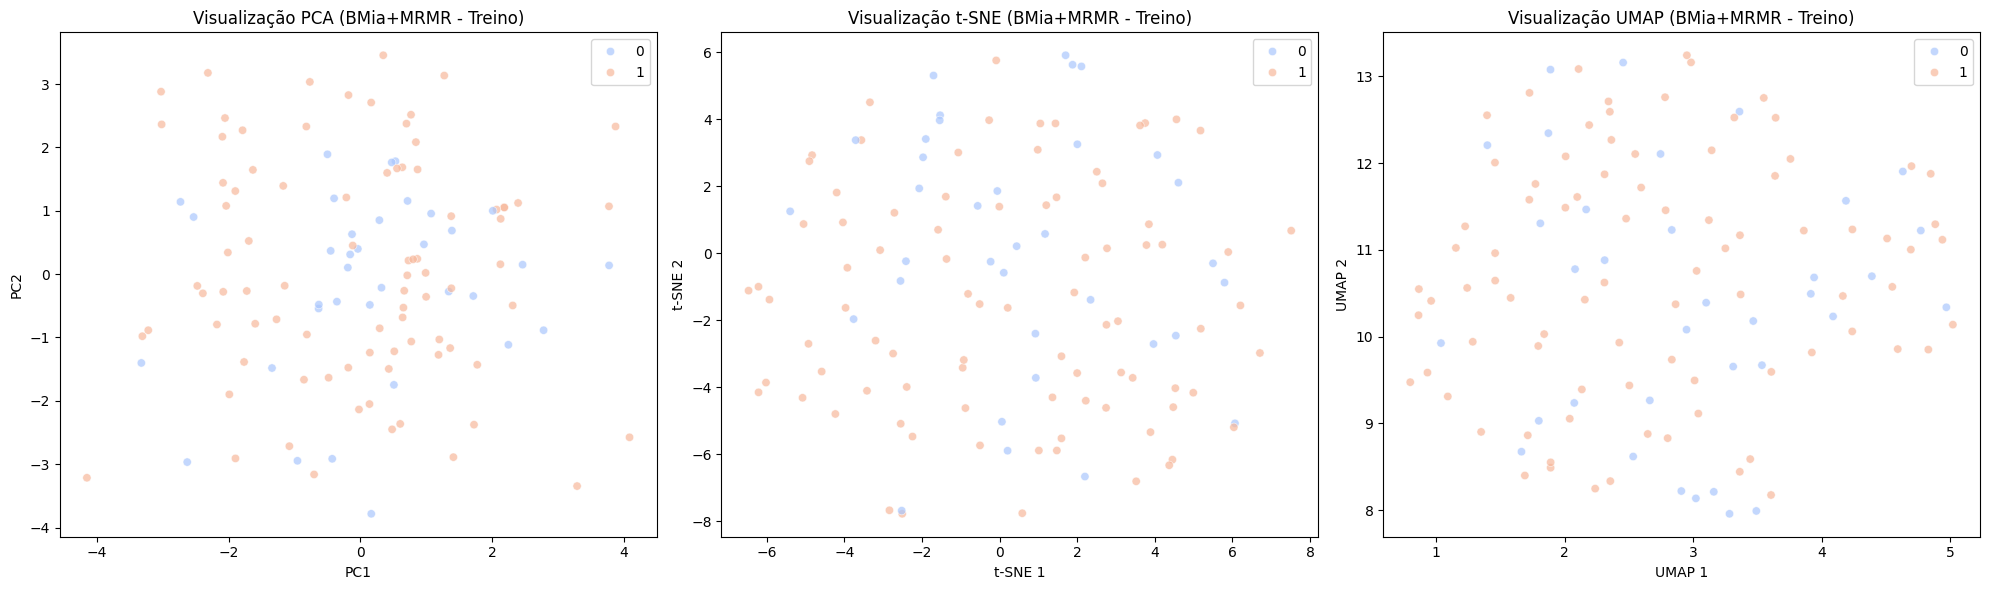


-> Treinando e avaliando RandomForest com BMia+MRMR

Optimizing hyperparameters for RandomForest with 10 features...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for RandomForest:
{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15}
Best F1-score (CV): 0.5913
Treinando modelo final RandomForest com melhores parâmetros em dados de treino processados ((120, 10))...
Avaliando modelo final RandomForest em dados de teste processados ((30, 10))...
  Resultados no Teste (BMia+MRMR - RandomForest):
    Accuracy: 0.6333
    F1-Score (Weighted): 0.5429
  Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.68      0.90      0.78        21

    accuracy                           0.63        30
   macro avg       0.34      0.45      0.39        30
weighted avg       0.47      0.63      0.54        30

Analisand

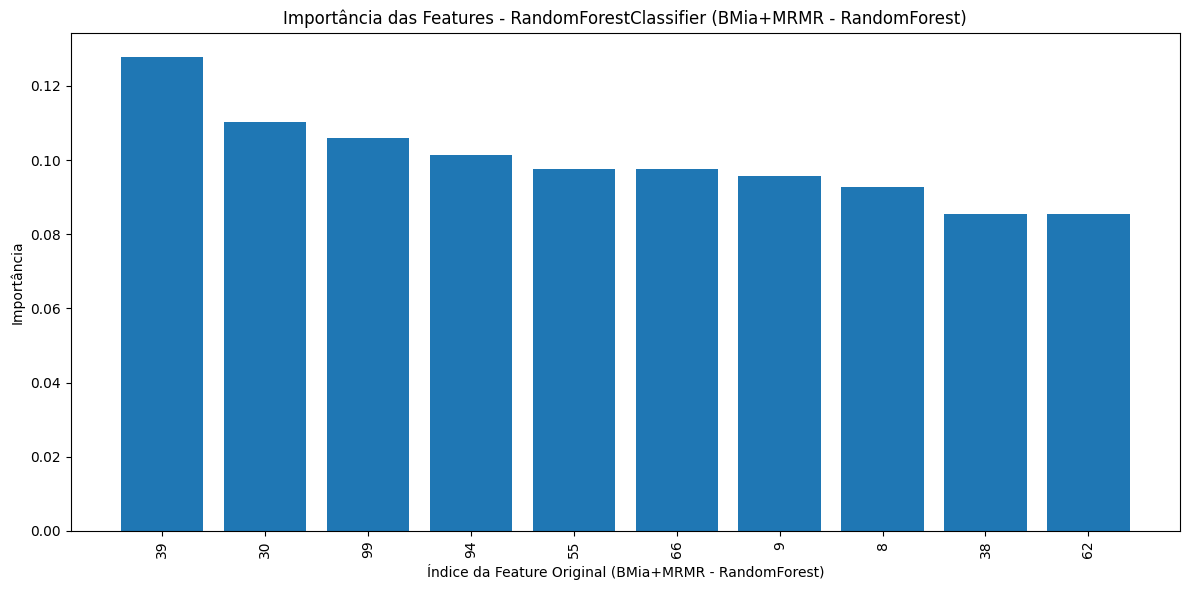

Top 10 features mais importantes (BMia+MRMR - RandomForest):
Feature 39: 0.1279
Feature 30: 0.1103
Feature 99: 0.1060
Feature 94: 0.1014
Feature 55: 0.0976
Feature 66: 0.0976
Feature 9: 0.0957
Feature 8: 0.0926
Feature 38: 0.0855
Feature 62: 0.0854

-> Treinando e avaliando SVM com BMia+MRMR

Optimizing hyperparameters for SVM with 10 features...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for SVM:
{'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
Best F1-score (CV): 0.6803
Treinando modelo final SVM com melhores parâmetros em dados de treino processados ((120, 10))...
Avaliando modelo final SVM em dados de teste processados ((30, 10))...
  Resultados no Teste (BMia+MRMR - SVM):
    Accuracy: 0.5333
    F1-Score (Weighted): 0.5148
  Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.11      0.12         9
           1       0.65      0.71      0.68        21

    accuracy                           0.5

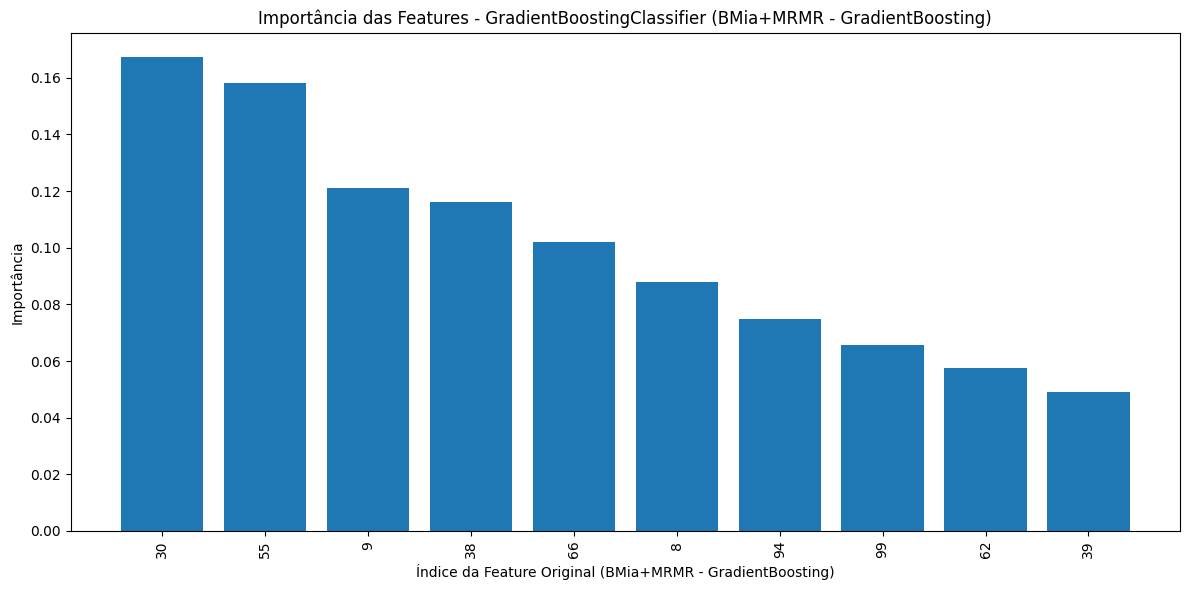

Top 10 features mais importantes (BMia+MRMR - GradientBoosting):
Feature 30: 0.1675
Feature 55: 0.1582
Feature 9: 0.1212
Feature 38: 0.1161
Feature 66: 0.1021
Feature 8: 0.0879
Feature 94: 0.0747
Feature 99: 0.0656
Feature 62: 0.0576
Feature 39: 0.0490

-> Treinando e avaliando KNeighbors com BMia+MRMR

Optimizing hyperparameters for KNeighbors with 10 features...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for KNeighbors:
{'weights': 'uniform', 'n_neighbors': 3, 'metric': 'euclidean'}
Best F1-score (CV): 0.6224
Treinando modelo final KNeighbors com melhores parâmetros em dados de treino processados ((120, 10))...
Avaliando modelo final KNeighbors em dados de teste processados ((30, 10))...
  Resultados no Teste (BMia+MRMR - KNeighbors):
    Accuracy: 0.5000
    F1-Score (Weighted): 0.5071
  Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.22      0.21         9
           1       0.65      0.

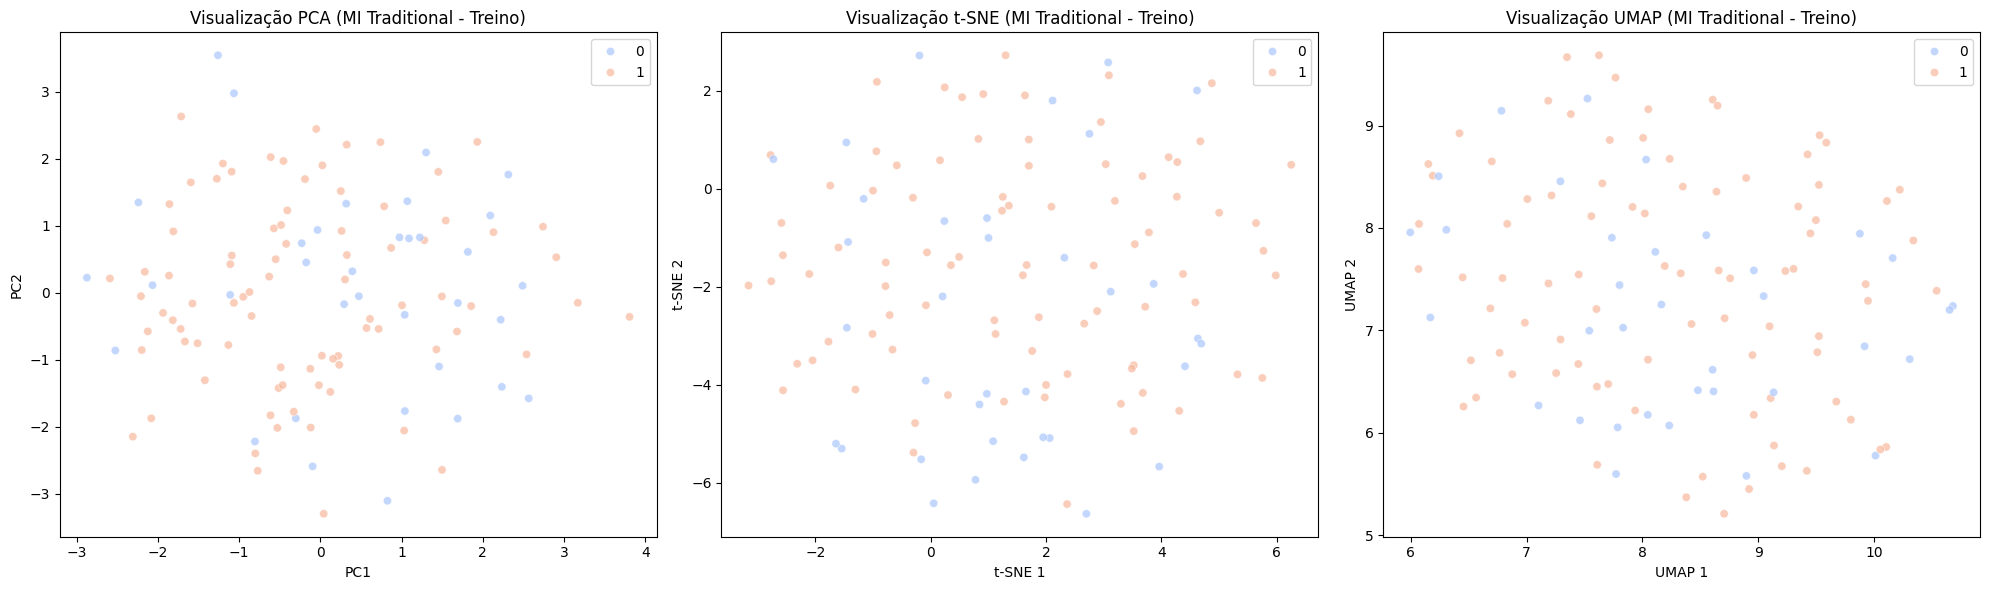


-> Treinando e avaliando RandomForest com MI Traditional

Optimizing hyperparameters for RandomForest with 30 features...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for RandomForest:
{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
Best F1-score (CV): 0.6558
Treinando modelo final RandomForest com melhores parâmetros em dados de treino processados ((120, 30))...
Avaliando modelo final RandomForest em dados de teste processados ((30, 30))...
  Resultados no Teste (MI Traditional - RandomForest):
    Accuracy: 0.6667
    F1-Score (Weighted): 0.5600
  Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.69      0.95      0.80        21

    accuracy                           0.67        30
   macro avg       0.34      0.48      0.40        30
weighted avg       0.48      0.67      0.56        30

A

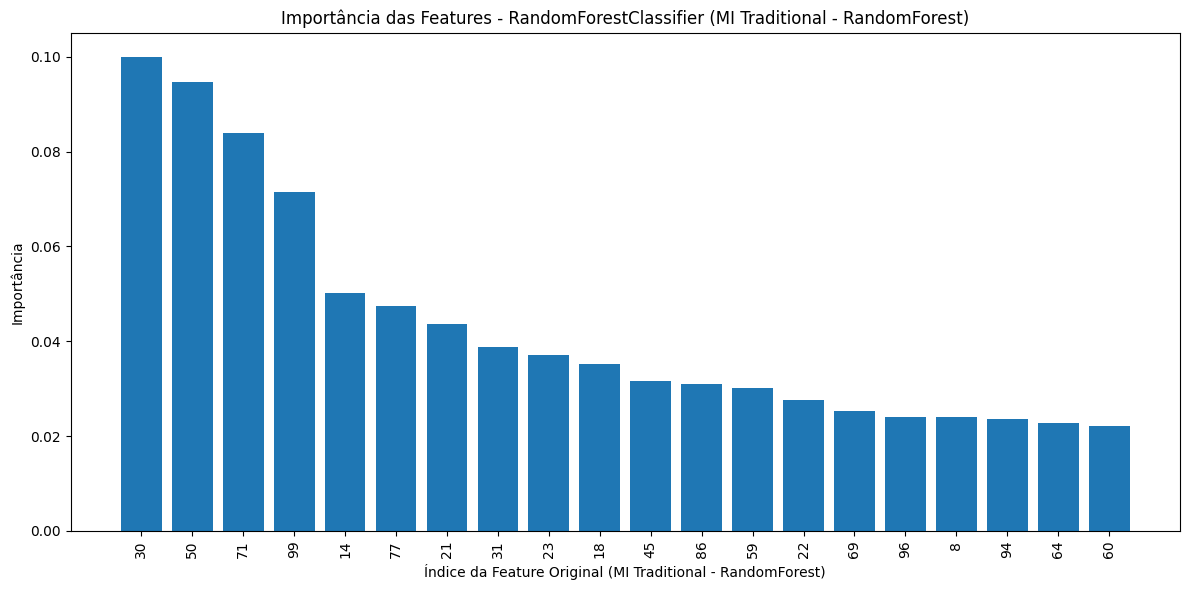

Top 10 features mais importantes (MI Traditional - RandomForest):
Feature 30: 0.1001
Feature 50: 0.0947
Feature 71: 0.0838
Feature 99: 0.0715
Feature 14: 0.0502
Feature 77: 0.0473
Feature 21: 0.0437
Feature 31: 0.0389
Feature 23: 0.0372
Feature 18: 0.0351

-> Treinando e avaliando SVM com MI Traditional

Optimizing hyperparameters for SVM with 30 features...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for SVM:
{'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
Best F1-score (CV): 0.6579
Treinando modelo final SVM com melhores parâmetros em dados de treino processados ((120, 30))...
Avaliando modelo final SVM em dados de teste processados ((30, 30))...
  Resultados no Teste (MI Traditional - SVM):
    Accuracy: 0.5333
    F1-Score (Weighted): 0.4870
  Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.64      0.76      0.70        21

    accuracy               

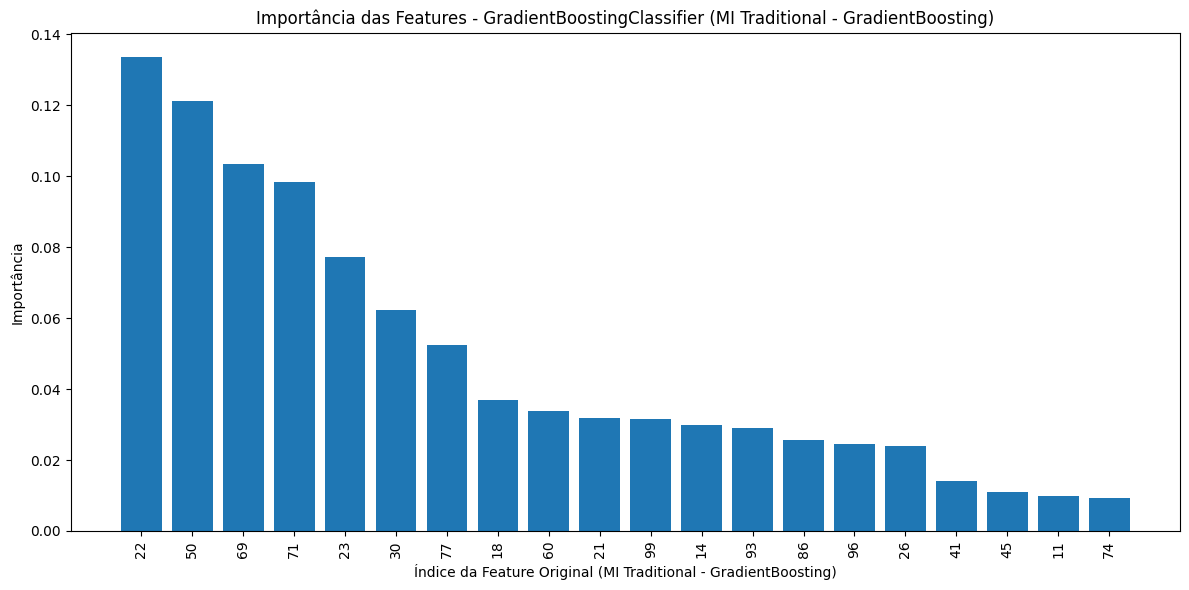

Top 10 features mais importantes (MI Traditional - GradientBoosting):
Feature 22: 0.1337
Feature 50: 0.1212
Feature 69: 0.1035
Feature 71: 0.0984
Feature 23: 0.0772
Feature 30: 0.0622
Feature 77: 0.0523
Feature 18: 0.0369
Feature 60: 0.0338
Feature 21: 0.0319

-> Treinando e avaliando KNeighbors com MI Traditional

Optimizing hyperparameters for KNeighbors with 30 features...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for KNeighbors:
{'weights': 'uniform', 'n_neighbors': 3, 'metric': 'euclidean'}
Best F1-score (CV): 0.7312
Treinando modelo final KNeighbors com melhores parâmetros em dados de treino processados ((120, 30))...
Avaliando modelo final KNeighbors em dados de teste processados ((30, 30))...
  Resultados no Teste (MI Traditional - KNeighbors):
    Accuracy: 0.5667
    F1-Score (Weighted): 0.5064
  Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1  

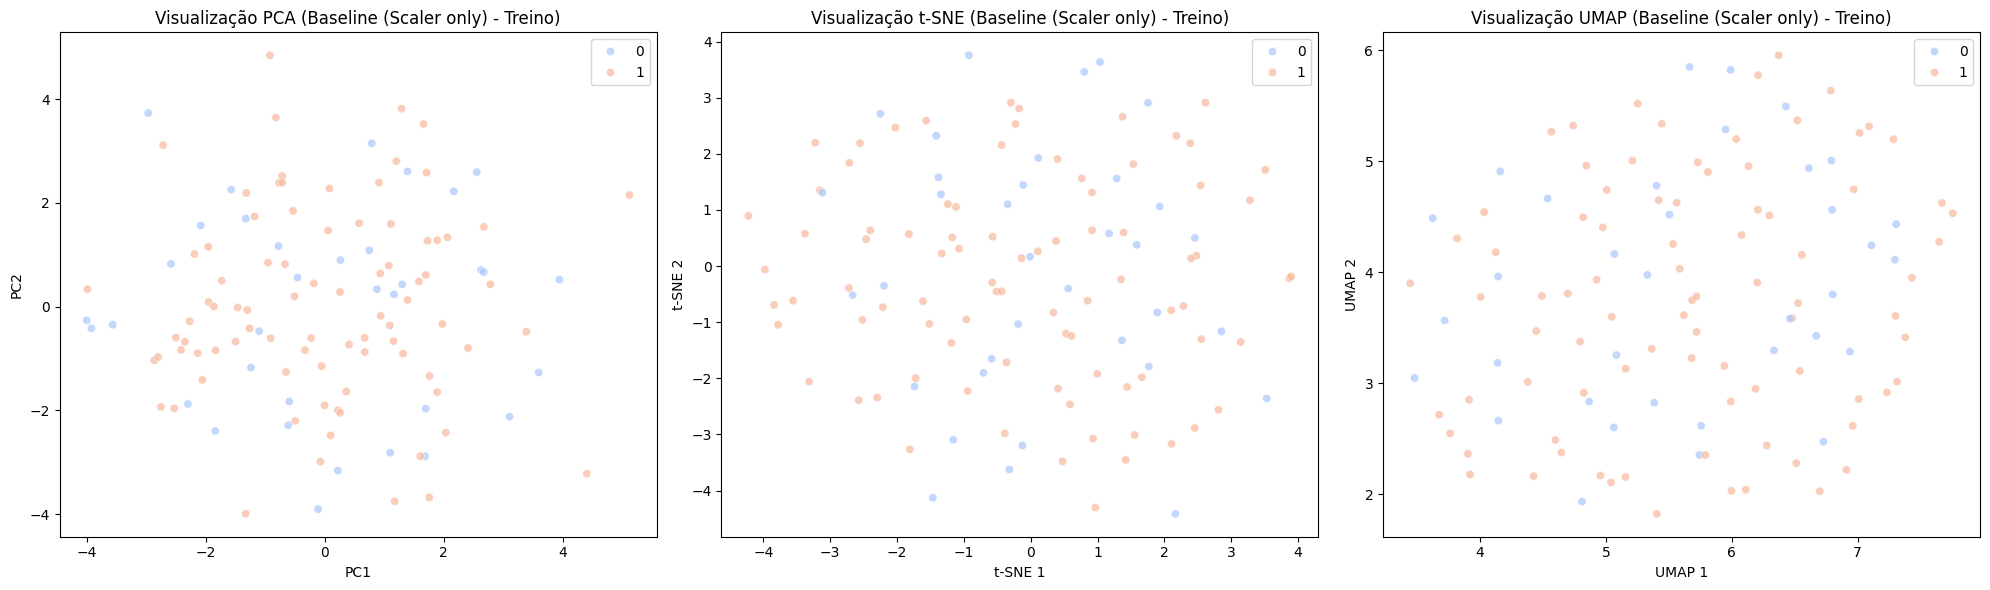


-> Treinando e avaliando RandomForest com Baseline (Scaler only)

Optimizing hyperparameters for RandomForest with 100 features...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for RandomForest:
{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15}
Best F1-score (CV): 0.6224
Treinando modelo final RandomForest com melhores parâmetros em dados de treino processados ((120, 100))...
Avaliando modelo final RandomForest em dados de teste processados ((30, 100))...
  Resultados no Teste (Baseline (Scaler only) - RandomForest):
    Accuracy: 0.7000
    F1-Score (Weighted): 0.5765
  Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.70      1.00      0.82        21

    accuracy                           0.70        30
   macro avg       0.35      0.50      0.41        30
weighted avg       0.49      0.70  

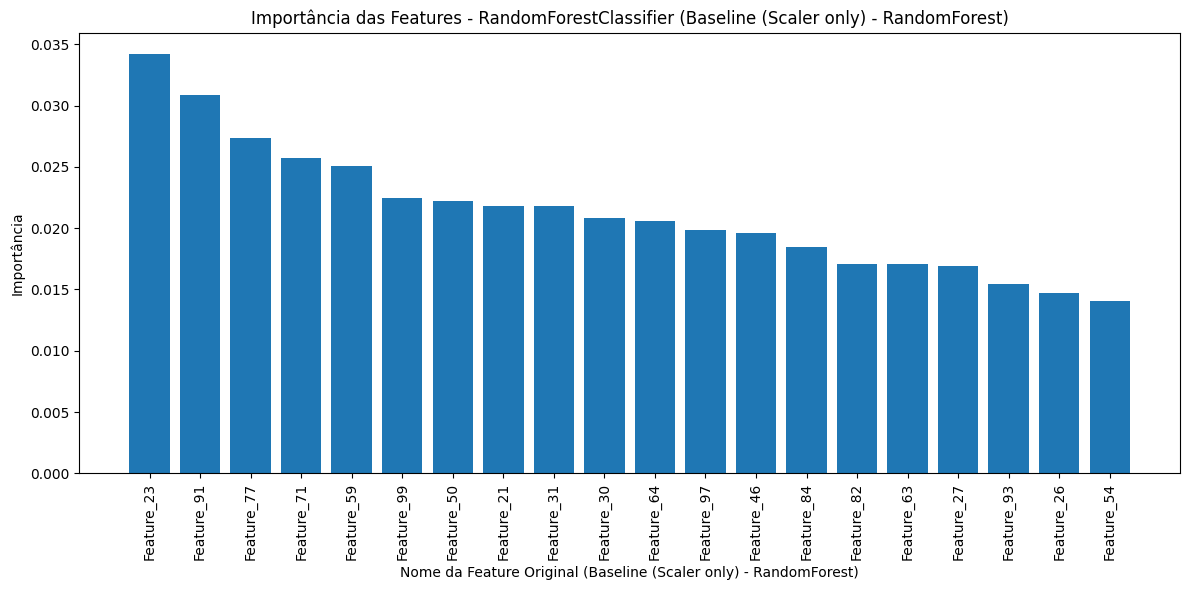

Top 10 features mais importantes (Baseline (Scaler only) - RandomForest):
Feature Feature_23: 0.0342
Feature Feature_91: 0.0309
Feature Feature_77: 0.0273
Feature Feature_71: 0.0257
Feature Feature_59: 0.0251
Feature Feature_99: 0.0225
Feature Feature_50: 0.0222
Feature Feature_21: 0.0218
Feature Feature_31: 0.0218
Feature Feature_30: 0.0208

-> Treinando e avaliando SVM com Baseline (Scaler only)

Optimizing hyperparameters for SVM with 100 features...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for SVM:
{'kernel': 'linear', 'gamma': 'scale', 'C': 1}
Best F1-score (CV): 0.6075
Treinando modelo final SVM com melhores parâmetros em dados de treino processados ((120, 100))...
Avaliando modelo final SVM em dados de teste processados ((30, 100))...
  Resultados no Teste (Baseline (Scaler only) - SVM):
    Accuracy: 0.5333
    F1-Score (Weighted): 0.5333
  Classification Report:
              precision    recall  f1-score   support

           0       0.22 

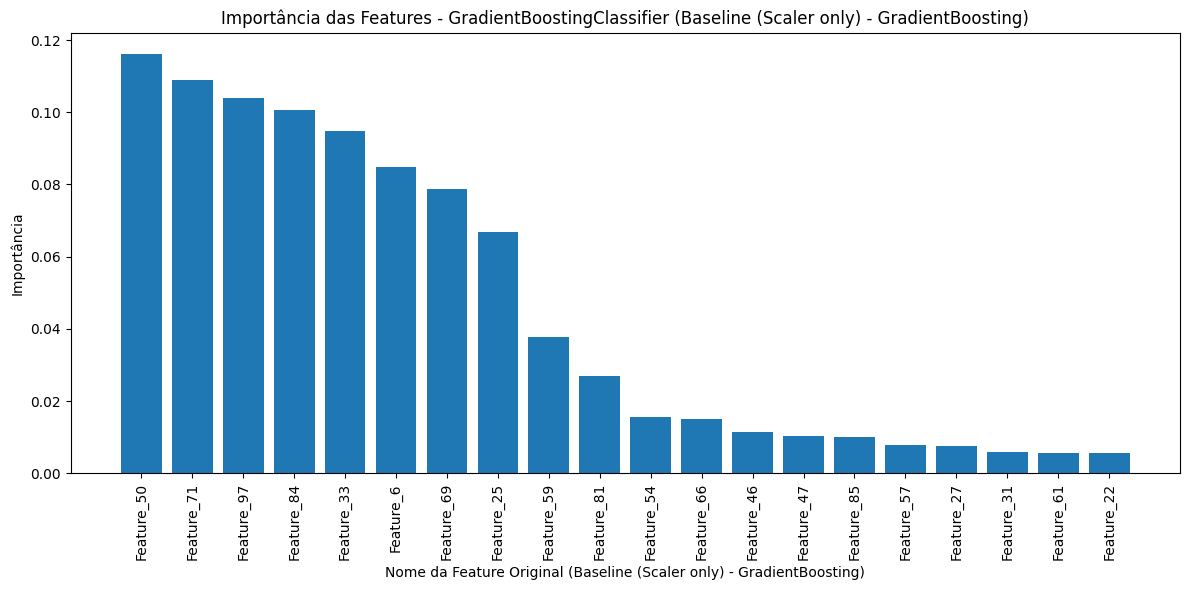

Top 10 features mais importantes (Baseline (Scaler only) - GradientBoosting):
Feature Feature_50: 0.1162
Feature Feature_71: 0.1089
Feature Feature_97: 0.1041
Feature Feature_84: 0.1006
Feature Feature_33: 0.0948
Feature Feature_6: 0.0849
Feature Feature_69: 0.0787
Feature Feature_25: 0.0669
Feature Feature_59: 0.0377
Feature Feature_81: 0.0270

-> Treinando e avaliando KNeighbors com Baseline (Scaler only)

Optimizing hyperparameters for KNeighbors with 100 features...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for KNeighbors:
{'weights': 'uniform', 'n_neighbors': 3, 'metric': 'manhattan'}
Best F1-score (CV): 0.6142
Treinando modelo final KNeighbors com melhores parâmetros em dados de treino processados ((120, 100))...
Avaliando modelo final KNeighbors em dados de teste processados ((30, 100))...
  Resultados no Teste (Baseline (Scaler only) - KNeighbors):
    Accuracy: 0.6333
    F1-Score (Weighted): 0.5823
  Classification Report:
              pre

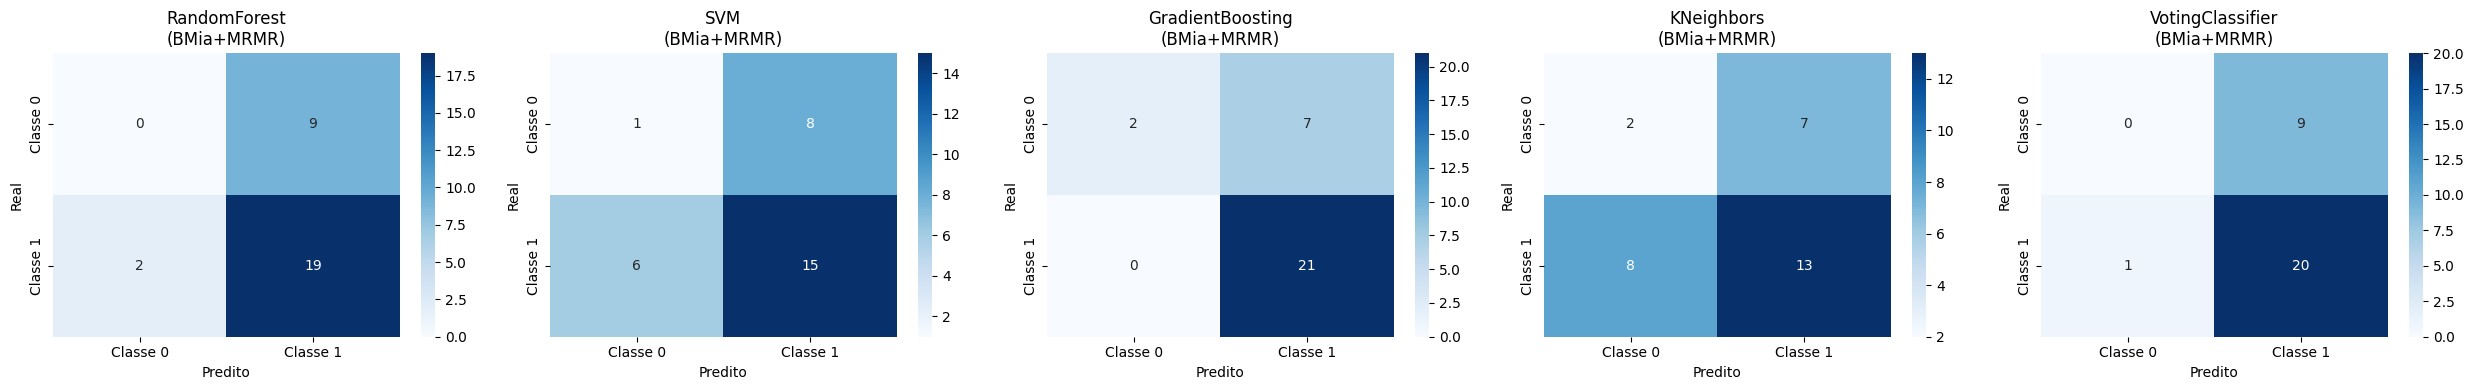


Matrizes de Confusão para: MI Traditional


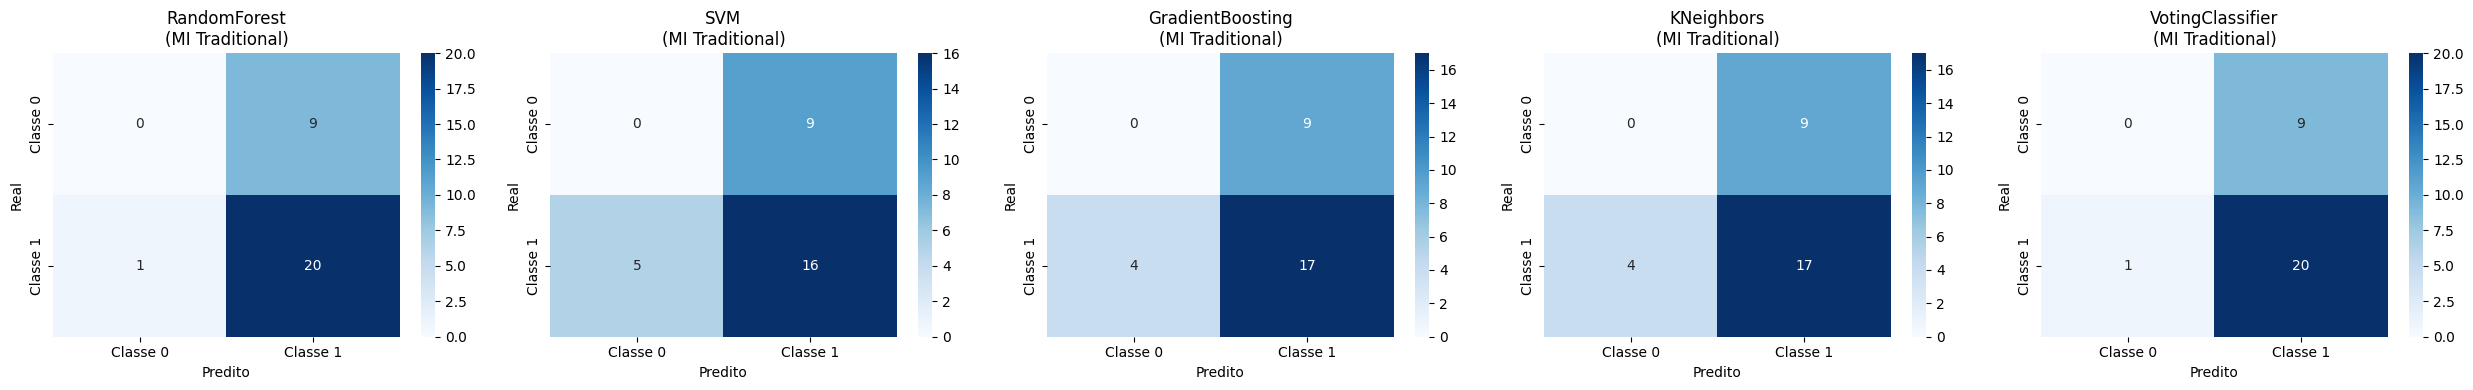


Matrizes de Confusão para: Baseline (Scaler only)


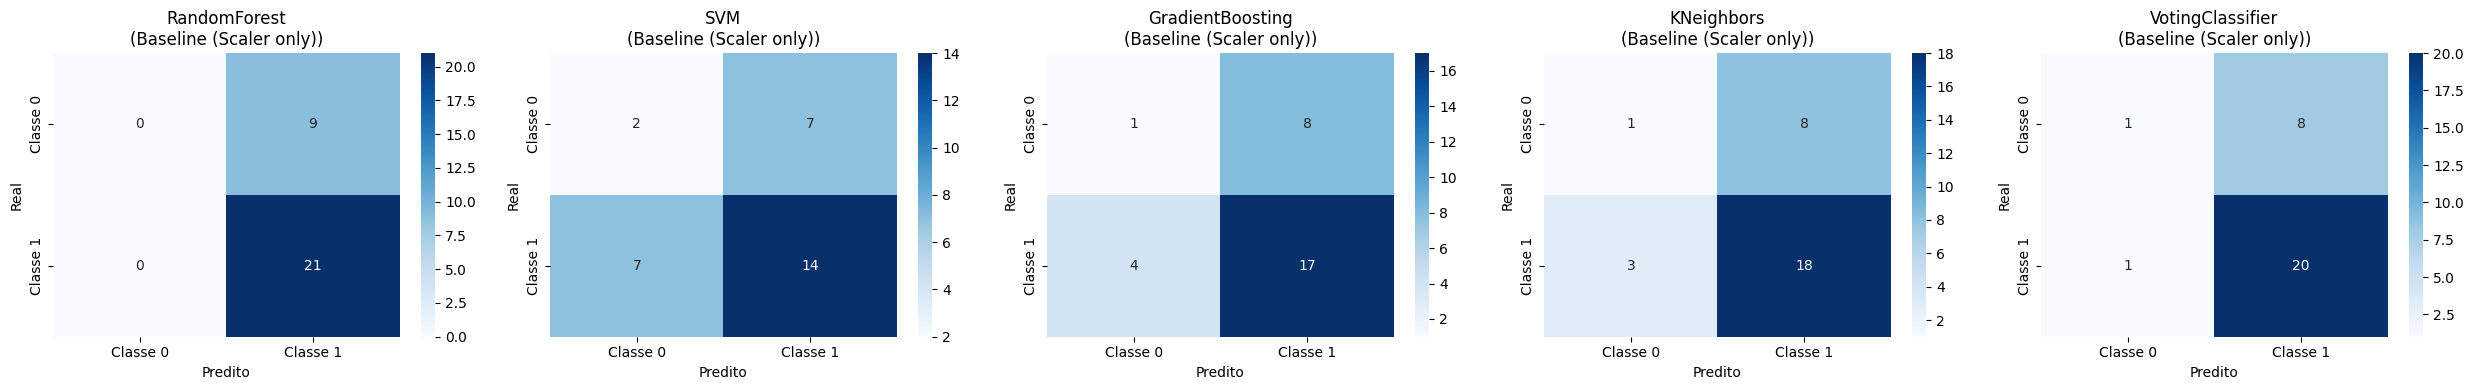


Análise Completa Finalizada.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif, SelectKBest
# Importação da biblioteca mrmr
# Certifique-se de que a biblioteca 'mrmr' está instalada (pip install mrmr_selection)
try:
    from mrmr import mrmr_classif
except ImportError:
    print("A biblioteca 'mrmr_selection' não foi encontrada. Instale-a usando: pip install mrmr_selection")
    # Crie uma função dummy ou pule a parte do MRMR se a biblioteca não estiver instalada
    def mrmr_classif(*args, **kwargs):
        print("Função mrmr_classif não disponível. Instalando a biblioteca 'mrmr_selection' pode resolver.")
        raise NotImplementedError("MRMR library not installed.")


import warnings

# Ignorar avisos
warnings.filterwarnings('ignore', category=UserWarning)

# --- Definir o novo target ---
def binarize_target(y, threshold=100):
    """
    Transforma a variável contínua em binária.
    Valores >= threshold são críticos (1) e os demais seguros (0).
    """
    return (y >= threshold).astype(int)

# --- Definir o novo target ---
def binarize_target(y, threshold=100):
    """
    Transforma a variável contínua em binária.
    Valores >= threshold são críticos (1) e os demais seguros (0).
    """
    return (y >= threshold).astype(int)

# --- Função de Discretização ---
# Mantida como função utilitária, mas a lógica principal está agora nos pipelines
def discretize_data(X, n_bins=3):
    """
    Discretiza dados contínuos usando KBinsDiscretizer.
    Não mais usado diretamente no pipeline, a pipeline conterá o discretizador.
    """
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    X_disc = discretizer.fit_transform(X)
    # Convertendo para int, pois encode='ordinal' retorna float
    return X_disc.astype(int)

# --- Transformador Customizado para Seleção Híbrida (BMia + MRMR) ---
class HybridFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Seleciona features usando uma abordagem híbrida:
    1. Filtra features discretizadas por percentil de MI.
    2. Aplica MRMR no subconjunto filtrado.
    """
    def __init__(self, bmia_percentile=95, mrmr_k=25):
        self.bmia_percentile = bmia_percentile  # Percentil para filtrar por MI
        self.mrmr_k = mrmr_k  # Número final de features a serem selecionadas pelo MRMR
        self.final_features_ = None  # Índices das features selecionadas no dataset original
        self.bmia_features = None  # Índices das features selecionadas após o filtro MI
        self.feature_importance_ = None  # Scores de MI das features originais discretizadas
        self.n_features_out_ = 0  # Store the number of features selected
        self._is_fitted = False # Adiciona um flag para verificar se fit foi chamado

    def fit(self, X, y):
        # X aqui JÁ DEVE TER PASSADO PELO ESCALONADOR E DISCRETIZADOR NO PIPELINE.
        # O tipo de dados deve ser int ou float que representa inteiros.
        if not np.issubdtype(X.dtype, (np.integer, np.floating)):
             print(f"Aviso: Os dados de entrada para HybridFeatureSelector não parecem ser inteiros/floats binned. Tipo: {X.dtype}")
        # Se o discretizador produz floats que são essencialmente inteiros, isso pode acontecer.

        n_samples, n_features = X.shape

        if n_features == 0:
            print("Aviso: Nenhuma feature de entrada para HybridFeatureSelector. Pulando seleção.")
            self.final_features_ = []
            self.n_features_out_ = 0
            self._is_fitted = True
            return self

        # 1. Utiliza BMia (MI em dados discretos) para filtrar as features
        # Ensure y is flat
        y_flat = y.ravel() if y.ndim > 1 else y

        try:
            # MI requires non-negative integers for discrete features if X is integer type
            # If X is float after discretization, mutual_info_classif treats it as continuous
            # Let's explicitly check the type and inform mutual_info_classif
            if np.issubdtype(X.dtype, np.integer):
                 mi_scores = mutual_info_classif(X, y_flat, discrete_features=True, random_state=42)
            else: # Assume it's float after discretization
                 mi_scores = mutual_info_classif(X, y_flat, discrete_features='auto', random_state=42) # 'auto' lets it decide
                 print("Aviso: Dados discretizados são float. mutual_info_classif trata como contínuo ou usa 'auto'.")

        except Exception as e:
             print(f"Erro ao calcular MI scores: {e}")
             print("Pulando seleção de features.")
             self.final_features_ = []
             self.n_features_out_ = 0
             self._is_fitted = True
             return self


        self.feature_importance_ = mi_scores

        # Calcula o limiar do percentil. Handle case where percentile is 100
        if self.bmia_percentile >= 100:
             threshold = np.max(mi_scores) * 0.99 # Select features with max MI or close to it
             print(f"Percentil >= 100. Usando limiar baseado no máximo MI ({threshold:.4f}).")
        else:
             threshold = np.percentile(mi_scores, self.bmia_percentile)

        # Seleciona os índices das features cujos scores de MI estão acima ou iguais ao limiar
        self.bmia_features = np.where(mi_scores >= threshold)[0]

        print(f"BMia filter selected {len(self.bmia_features)} features.")

        # Verifica se há features selecionadas após o filtro MI
        if len(self.bmia_features) == 0:
            print("Aviso: Nenhuma feature selecionada após filtro MI. MRMR não será aplicado.")
            self.final_features_ = []
            self.n_features_out_ = 0
            self._is_fitted = True
            return self

        # Ajusta mrmr_k se o número de features após a filtragem for menor que o desejado
        current_mrmr_k = self.mrmr_k
        mrmr_k_adjusted = min(current_mrmr_k, len(self.bmia_features))
        if mrmr_k_adjusted < current_mrmr_k:
             print(f"Aviso: O número de features após o filtro MI ({len(self.bmia_features)}) é menor que mrmr_k ({current_mrmr_k}). Ajustando mrmr_k para {mrmr_k_adjusted}.")
        if mrmr_k_adjusted == 0:
             print("Aviso: mrmr_k ajustado é 0. Nenhuma feature será selecionada pelo MRMR.")
             self.final_features_ = []
             self.n_features_out_ = 0
             self._is_fitted = True
             return self


        # 2. Aplica MRMR no subconjunto filtrado
        # A biblioteca mrmr espera um DataFrame do pandas com nomes de colunas string
        # Cria um DataFrame apenas com as features selecionadas pelo filtro MI
        # Garante que X_bmia tem o tipo esperado pelo mrmr_classif (float ou int)
        X_bmia_subset = X[:, self.bmia_features]
        df_X_bmia = pd.DataFrame(X_bmia_subset)
        # Cria nomes de colunas que mapeiam de volta para os índices originais no subconjunto BMia
        # Isso é crucial para mapear de volta para os índices originais das features em X
        df_X_bmia.columns = [f"bmia_subset_idx_{i}" for i in range(df_X_bmia.shape[1])]

        # Apply MRMR
        # mrmr_classif returns a list with the names of the selected columns
        try:
            # Ensure y is a pandas Series or numpy array for mrmr_classif
            y_mrmr = pd.Series(y_flat, name='target')
            selected_names = mrmr_classif(df_X_bmia, y_mrmr, K=mrmr_k_adjusted, show_progress=False) # show_progress=False para evitar output excessivo durante o fit

            # Map the selected column names back to the original feature indices
            # Extract the index from the BMia subset (e.g., 'bmia_subset_idx_5' -> 5)
            bmia_subset_indices_selected_by_mrmr = [int(col.split('_')[-1]) for col in selected_names]
            # Use these indices to get the original feature indices from the self.bmia_features list
            self.final_features_ = [self.bmia_features[i] for i in bmia_subset_indices_selected_by_mrmr]
            self.n_features_out_ = len(self.final_features_)

            print(f"MRMR selected {self.n_features_out_} features.")
        except Exception as e:
            print(f"Erro ao aplicar MRMR: {e}")
            print("Usando as features do filtro BMia como resultado final.")
            self.final_features_ = self.bmia_features # Fallback
            self.n_features_out_ = len(self.final_features_)

        self._is_fitted = True
        return self

    def transform(self, X):
        if not self._is_fitted:
             raise RuntimeError("This HybridFeatureSelector instance is not fitted yet. Call 'fit' before using this method.")

        # Return only the columns selected by the hybrid process
        if self.final_features_ is None or self.n_features_out_ == 0:
            # Return an empty array with the correct number of samples but 0 features
            print("Aviso: Transform chamado, mas nenhuma feature selecionada. Retornando array vazio.")
            return np.empty((X.shape[0], 0))

        # Garante que selecionamos apenas features válidas
        # Isso pode acontecer se o transform for chamado em um X com menos colunas que o X usado para fit
        valid_indices = [idx for idx in self.final_features_ if idx < X.shape[1]]
        if len(valid_indices) < len(self.final_features_):
             print(f"Aviso: Alguns índices de features selecionados no fit ({len(self.final_features_)}) são inválidos para este X ({X.shape[1]} colunas). Usando apenas {len(valid_indices)} features válidas.")
             self.final_features_ = valid_indices # Update internal state for safety, although transform should not change state
             self.n_features_out_ = len(valid_indices)
             if len(valid_indices) == 0:
                  print("Aviso: Nenhuma feature válida restante para transformação. Retornando array vazio.")
                  return np.empty((X.shape[0], 0))


        # Select the features using the valid indices
        X_transformed = X[:, self.final_features_]

        return X_transformed

    def get_feature_indices(self):
        """Retorna os índices das features selecionadas no dataset original."""
        return self.final_features_

    def get_n_features_out(self):
        """Retorna o número de features selecionadas."""
        return self.n_features_out_


# --- Pipeline Completo para BMia+MRMR ---
def create_bmia_mrmr_pipeline(mrmr_k=25, n_bins=3, bmia_percentile=95):
    """
    Cria o pipeline completo para pré-processamento e seleção de features com BMia+MRMR.
    Passos: Escalonamento -> Discretização -> Seleção Híbrida (BMia + MRMR).
    """
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # 1. Escala os dados contínuos
        ('discretizer', KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile', subsample=None)), # 2. Discretiza. subsample=None para usar todos os dados no fit
        ('hybrid_selector', HybridFeatureSelector(bmia_percentile=bmia_percentile, mrmr_k=mrmr_k))  # 3. Seleção híbrida
    ])
    return pipeline

# --- Pipeline para MI Tradicional ---
def create_mi_pipeline(k=25):
    """
    Cria o pipeline para pré-processamento (escalonamento) e seleção de features com MI tradicional.
    Aplica MI em dados escalonados (tratados como contínuos para MI tradicional).
    """
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # 1. Escala os dados contínuos
        # 2. SelectKBest with mutual_info_classif for continuous data (uses MI estimation)
        ('mi_selector', SelectKBest(score_func=mutual_info_classif, k=k))
    ])
    return pipeline

# --- Pipeline Baseline (apenas escalonamento) ---
def create_baseline_pipeline():
    """
    Cria um pipeline baseline que apenas escala os dados.
    Sem seleção de features.
    """
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Apenas escala os dados contínuos
        # Sem seleção de features, passa todos os dados escalonados
    ])
    return pipeline


# --- Função de Avaliação com StratifiedKFold ---
# Esta função é útil para obter uma estimativa robusta da performance NO CONJUNTO DE TREINO PROCESSADO.
# Para a avaliação FINAL, usaremos o modelo treinado no TREINO PROCESSADO e avaliado no TESTE PROCESSADO.
def evaluate_model_cv(X_processed, y_train, model, n_splits=5, n_repeats=3):
    """
    Avalia um modelo usando StratifiedKFold (para lidar com desbalanceamento)
    e retorna as médias de acurácia e F1-Score.
    Assume que X_processed e y_train JÁ ESTÃO PRÉ-PROCESSADOS E COM FEATURES SELECIONADAS.
    """
    if X_processed is None or X_processed.shape[1] == 0:
        print("Aviso: Não é possível avaliar o modelo CV: Dados de treino processados indisponíveis ou 0 features.")
        return None, None

    print(f"Avaliando modelo CV ({type(model).__name__}) em dados processados ({X_processed.shape})...")

    # Use StratifiedKFold to ensure class distribution in each fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    acc_scores, f1_scores = [], []

    # For RepeatedKFold stratified, we can use StratifiedKFold inside a repetition loop
    for repeat in range(n_repeats):
        # Use a diferente random_state para cada repetição se desejar mais variação,
        # ou o mesmo para resultados mais determinísticos entre repetições.
        # skf_repeat = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42 + repeat)
        skf_repeat = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) # Mantendo o mesmo random_state por simplicidade aqui

        for train_idx_cv, test_idx_cv in skf_repeat.split(X_processed, y_train):
            # CORREÇÃO: A indexação já estava correta no código original para X,
            # mas o comentário estava confuso. As variáveis train_idx e test_idx
            # referem-se aos índices DENTRO do X_processed/y_train.
            X_train_cv, X_test_cv = X_processed[train_idx_cv], X_processed[test_idx_cv]
            y_train_cv, y_test_cv = y_train[train_idx_cv], y_train[test_idx_cv]

            # The model here is just the classifier (RF, SVM, etc.)
            model.fit(X_train_cv, y_train_cv)
            y_pred = model.predict(X_test_cv)

            acc_scores.append(accuracy_score(y_test_cv, y_pred))
            f1_scores.append(f1_score(y_test_cv, y_pred, average='weighted'))  # Use weighted F1 for imbalance

    return np.mean(acc_scores), np.mean(f1_scores)


# --- Visualizações Avançadas ---
# Mantida, mas chamada no fluxo principal após o pré-processamento
def visualize_data_reduction(X_proc, y, title_suffix=""):
    """
    Visualizes reduced data using PCA, t-SNE, and UMAP.
    Expects already processed data (X_proc).
    """
    n_samples, n_features = X_proc.shape

    if n_features < 2:
        print(f"Cannot visualize reduced data with less than 2 features. {title_suffix}")
        return
    if n_samples < 2:
         print(f"Cannot visualize reduced data with less than 2 samples. {title_suffix}")
         return


    # PCA
    try:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_proc)
    except Exception as e:
        print(f"Error running PCA ({title_suffix}): {e}")
        X_pca = np.zeros((n_samples, 2))  # Placeholder

    # t-SNE with perplexity adjusted for small dataset
    perplexity_val = min(30, n_samples - 1)
    if perplexity_val <= 1:
        print(f"Cannot run t-SNE with {n_samples} samples. Perplexity needs at least 2 samples. {title_suffix}")
        X_tsne = np.zeros((n_samples, 2))  # Placeholder
    else:
        try:
            # Use 'exact' solver for small datasets if needed, but 'barnes_hut' is faster for larger
            # init='pca' is often more robust
            tsne = TSNE(n_components=2, perplexity=perplexity_val, random_state=42, init='pca', learning_rate='auto')
            X_tsne = tsne.fit_transform(X_proc)
        except Exception as e:
            print(f"Error running t-SNE ({title_suffix}): {e}")
            X_tsne = np.zeros((n_samples, 2))  # Placeholder

    # UMAP
    n_neighbors_val = min(15, n_samples - 1)
    if n_neighbors_val <= 1:
        print(f"Cannot run UMAP with {n_samples} samples. n_neighbors needs at least 2 samples. {title_suffix}")
        X_umap = np.zeros((n_samples, 2))  # Placeholder
    else:
        try:
            reducer = umap.UMAP(n_neighbors=n_neighbors_val, min_dist=0.1, random_state=42)
            X_umap = reducer.fit_transform(X_proc)
        except Exception as e:
            print(f"Error running UMAP ({title_suffix}): {e}")
            X_umap = np.zeros((n_samples, 2))  # Placeholder

    # Visualizations
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Check if output data has 2 components before plotting
    if X_pca.shape[1] == 2 and X_pca.shape[0] > 0:
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="coolwarm", alpha=0.7, ax=axes[0])
        axes[0].set_title(f"Visualização PCA {title_suffix}")
        axes[0].set_xlabel("PC1")
        axes[0].set_ylabel("PC2")
    else:
        axes[0].set_title(f"PCA Indisponível {title_suffix}")
        axes[0].text(0.5, 0.5, "Dados insuficientes ou erro", horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)

    if X_tsne.shape[1] == 2 and X_tsne.shape[0] > 0:
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="coolwarm", alpha=0.7, ax=axes[1])
        axes[1].set_title(f"Visualização t-SNE {title_suffix}")
        axes[1].set_xlabel("t-SNE 1")
        axes[1].set_ylabel("t-SNE 2")
    else:
        axes[1].set_title(f"t-SNE Indisponível {title_suffix}")
        axes[1].text(0.5, 0.5, "Dados insuficientes ou erro", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

    if X_umap.shape[1] == 2 and X_umap.shape[0] > 0:
        sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette="coolwarm", alpha=0.7, ax=axes[2])
        axes[2].set_title(f"Visualização UMAP {title_suffix}")
        axes[2].set_xlabel("UMAP 1")
        axes[2].set_ylabel("UMAP 2")
    else:
        axes[2].set_title(f"UMAP Indisponível {title_suffix}")
        axes[2].text(0.5, 0.5, "Dados insuficientes ou erro", horizontalalignment='center', verticalalignment='center', transform=axes[2].transAxes)

    plt.tight_layout()
    plt.show()


# --- Analyze Confusion Matrices ---
# Mantida, mas chamada no fluxo principal com os resultados finais do teste
def analyze_confusion_matrices(models, X_test_proc_dict, y_test):
    """
    Plots confusion matrices for multiple models and processed test datasets.
    X_test_proc_dict should be a dictionary {method_name: processed_X_test}.
    models should be a dictionary {model_name: fitted_model}.
    """
    # Verificação para remover modelos nulos ou conjuntos de dados vazios
    models_filtered = {k: v for k, v in models.items() if v is not None}
    # Verifica se o conjunto de dados não é None e tem pelo menos 2 colunas (para ter uma matriz visualmente útil)
    X_test_proc_dict_filtered = {k: v for k, v in X_test_proc_dict.items() if v is not None and v.shape[1] >= 1}

    if not models_filtered or not X_test_proc_dict_filtered:
        print("Nenhum modelo válido ou conjunto de dados para criar matrizes de confusão.")
        return

    n_models = len(models_filtered)
    n_datasets = len(X_test_proc_dict_filtered)

    # Adjust figure size based on the number of matrices
    fig, axes = plt.subplots(n_datasets, n_models, figsize=(5 * n_models, 4 * n_datasets), squeeze=False) # squeeze=False ensures axes is always 2D

    # Criação das matrizes de confusão
    for i, (data_name, X_test_proc) in enumerate(X_test_proc_dict_filtered.items()):
        for j, (model_name, model) in enumerate(models_filtered.items()):
            # Verificação adicional antes de fazer a predição
            try:
                if X_test_proc.shape[1] == 0:
                     print(f"Não é possível prever para {model_name} com {data_name}: 0 features.")
                     axes[i, j].set_title(f'{model_name}\n({data_name})\n0 features')
                     axes[i, j].text(0.5, 0.5, "0 features", horizontalalignment='center', verticalalignment='center', transform=axes[i, j].transAxes)
                     continue # Pula para o próximo modelo/dataset

                y_pred = model.predict(X_test_proc)
                cm = confusion_matrix(y_test, y_pred)

                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i, j],
                            xticklabels=['Classe 0', 'Classe 1'],
                            yticklabels=['Classe 0', 'Classe 1'])
                axes[i, j].set_title(f'{model_name}\n({data_name})')
                axes[i, j].set_ylabel('Real')
                axes[i, j].set_xlabel('Predito')
            except Exception as e:
                print(f"Erro ao criar matriz de confusão para {model_name} com {data_name}: {e}")
                axes[i, j].set_visible(False)  # Hide the subplot on error

    plt.tight_layout()
    plt.show()


# --- Analyze Feature Importance ---
# Mantida, chamada no fluxo principal após o treino para modelos aplicáveis
def analyze_feature_importance(model, feature_indices, method_name, original_feature_names=None):
    """
    Plots feature importance for tree-based models (RandomForest, GradientBoosting).
    feature_indices should map indices in the processed array back to original indices.
    original_feature_names is a list of names for the original features.
    """
    if not hasattr(model, 'feature_importances_'):
        print(f"Model {type(model).__name__} ({method_name}) does not have feature_importances_ attribute.")
        return
    if feature_indices is None or len(feature_indices) != len(model.feature_importances_):
        print(f"Warning: Feature indices issue for {method_name}. Cannot map back to original features reliably.")
        # Fallback to using processed indices if mapping is not possible
        feature_indices = np.arange(len(model.feature_importances_))
        use_original_names = False
    else:
         use_original_names = (original_feature_names is not None and len(original_feature_names) == len(feature_indices))
         if not use_original_names:
              print(f"Warning: Original feature names not provided or size mismatch for {method_name}. Using original indices.")


    importances = model.feature_importances_
    # Sort by importance (largest to smallest)
    sorted_indices_proc = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    # Plot only top N features for better visualization
    top_n = min(20, len(importances))
    plt.bar(range(top_n), importances[sorted_indices_proc[:top_n]])

    # Define X-axis ticks
    if use_original_names:
        # Map the sorted processed indices back to original names
        feature_names_sorted = [original_feature_names[feature_indices[i]] for i in sorted_indices_proc[:top_n]]
        plt.xticks(range(top_n), feature_names_sorted, rotation=90)
        plt.xlabel(f'Nome da Feature Original ({method_name})')
    else:
        # Map the sorted processed indices back to original indices
        original_indices_sorted = [feature_indices[i] for i in sorted_indices_proc[:top_n]]
        plt.xticks(range(top_n), original_indices_sorted, rotation=90)
        plt.xlabel(f'Índice da Feature Original ({method_name})')


    plt.title(f'Importância das Features - {type(model).__name__} ({method_name})')
    plt.ylabel('Importância')
    plt.tight_layout()
    plt.show()

    # Top 10 most important features
    print(f"Top 10 features mais importantes ({method_name}):")
    if use_original_names:
         top_features_info = [(feature_names_sorted[i], importances[sorted_indices_proc[i]]) for i in range(min(10, top_n))]
    else:
         top_features_info = [(original_indices_sorted[i], importances[sorted_indices_proc[i]]) for i in range(min(10, top_n))]

    for name_or_index, importance_value in top_features_info:
         print(f"Feature {name_or_index}: {importance_value:.4f}")


# --- Hyperparameter Optimization ---
# Mantida, chamada no fluxo principal antes de treinar o modelo final
def optimize_hyperparameters(X_train_proc, y_train, model_type='RandomForest', n_iter=30, cv_splits=5):
    """
    Optimizes hyperparameters for a model using RandomizedSearchCV.
    Returns the best estimator found.
    """
    if X_train_proc is None or X_train_proc.shape[1] == 0 or X_train_proc.shape[0] == 0:
        print(f"Cannot optimize {model_type}: Processed training data unavailable, 0 features, or 0 samples.")
        return None  # Return None if no features or samples

    print(f"\nOptimizing hyperparameters for {model_type} with {X_train_proc.shape[1]} features...")

    # Definição dos parâmetros para busca
    if model_type == 'RandomForest':
        param_grid = {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10, 15],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['sqrt', 'log2', None] # 'auto' is deprecated, use 'sqrt'
        }
        model = RandomForestClassifier(random_state=42)
    elif model_type == 'SVM':
        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.01, 0.1, 1],
            'kernel': ['rbf', 'linear']
        }
        model = SVC(random_state=42, probability=True)  # probability=True for soft voting in ensemble
    elif model_type == 'GradientBoosting':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        model = GradientBoostingClassifier(random_state=42)
    elif model_type == 'KNeighbors':
        param_grid = {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
        model = KNeighborsClassifier()
    else:
        print(f"Warning: Model {model_type} not supported for optimization. Returning default model.")
        # Retorna uma instância default do modelo se não suportado
        if model_type == 'RandomForest': return RandomForestClassifier(random_state=42)
        elif model_type == 'SVM': return SVC(random_state=42)
        elif model_type == 'GradientBoosting': return GradientBoostingClassifier(random_state=42)
        elif model_type == 'KNeighbors': return KNeighborsClassifier()
        else: return None


    # Use StratifiedKFold for CV in optimization to handle imbalance
    skf_cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    # Adjust parameters for small datasets
    # A busca por muitos hiperparâmetros pode não ser eficaz em datasets muito pequenos
    # Reduzindo n_iter e o número de splits do CV pode ser necessário
    current_n_iter = n_iter
    current_cv_splits = cv_splits

    if X_train_proc.shape[0] < 50: # Limiar arbitrário para "pequeno"
         current_n_iter = min(n_iter, 10)
         current_cv_splits = min(cv_splits, 3)
         print(f"Small dataset ({X_train_proc.shape[0]} samples), adjusting n_iter to {current_n_iter} and cv_splits to {current_cv_splits}.")
         if current_cv_splits < 2:
              print("Cannot perform CV with less than 2 splits.")
              return None # Não é possível fazer CV

    # Create and run RandomizedSearchCV
    try:
        search = RandomizedSearchCV(
            model, param_grid, n_iter=current_n_iter, cv=skf_cv, scoring='f1_weighted',
            random_state=42, n_jobs=-1, verbose=1
        )
        search.fit(X_train_proc, y_train)

        print(f"Best parameters for {model_type}:")
        print(search.best_params_)
        print(f"Best F1-score (CV): {search.best_score_:.4f}")

        return search.best_estimator_
    except ValueError as ve:
         print(f"Error during RandomizedSearchCV for {model_type}: {ve}")
         # Isso pode acontecer se o param_grid for incompatível ou os dados forem inválidos
         return None
    except Exception as e:
        print(f"An unexpected error occurred during optimization for {model_type}: {e}")
        return None


# --- Main Execution Block ---
if __name__ == "__main__":
    print("Iniciando a análise comparativa BMia+MRMR vs MI tradicional para detecção de gás.")

    # --- Configurações ---
    TARGET_COLUMN = '100ppb'
    THRESHOLD = 100 # Limiar para binarização
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    N_BINS_DISCRETIZATION = 5 # Número de bins para discretização no BMia+MRMR
    BMIA_PERCENTILE = 90 # Percentil para filtro inicial de MI no BMia+MRMR
    MRMR_K_FEATURES = 30 # Número final de features selecionadas pelo MRMR
    MI_K_FEATURES = 30 # Número de features selecionadas pelo MI tradicional
    OPTIMIZATION_ITER = 30 # Iterações para RandomizedSearchCV (ajustar conforme o tempo disponível)
    CV_SPLITS_OPTIMIZATION = 5 # Splits para CV na otimização
    EVALUATION_CV_SPLITS = 5 # Splits para CV na avaliação final (após seleção)
    EVALUATION_REPEATS = 2 # Repetições para avaliação CV

    # --- 1. Carregar Dados ---
    df = None
    file_path = "/content/gsalc.csv"
    try:
        df = pd.read_csv(file_path)
        print(f"Arquivo '{file_path}' carregado com sucesso.")

        # Tratamento do target (já existente no seu código)
        if TARGET_COLUMN in df.columns:
            # Remove 'ppb' se existir e converte para float
            if isinstance(df[TARGET_COLUMN].iloc[0], str):
                print(f"Removendo 'ppb' da coluna '{TARGET_COLUMN}'.")
                df[TARGET_COLUMN] = df[TARGET_COLUMN].astype(str).str.replace('ppb', '', regex=False).astype(float)
            # Verifica se a coluna é numérica após o tratamento
            elif not np.issubdtype(df[TARGET_COLUMN].dtype, np.number):
                 print(f"Erro: Coluna '{TARGET_COLUMN}' não é numérica após tentar remover 'ppb'. Tipo: {df[TARGET_COLUMN].dtype}")
                 # Tenta converter forçadamente ou trata o erro
                 try:
                      df[TARGET_COLUMN] = pd.to_numeric(df[TARGET_COLUMN], errors='coerce')
                      if df[TARGET_COLUMN].isnull().any():
                           print("Aviso: Alguns valores na coluna target não puderam ser convertidos para número e se tornaram NaN.")
                           df.dropna(subset=[TARGET_COLUMN], inplace=True) # Opcional: remover linhas com NaN no target
                 except Exception as e:
                      print(f"Erro fatal ao tentar converter a coluna '{TARGET_COLUMN}' para numérica: {e}")
                      df = None # Indica falha no carregamento/tratamento

        else:
            print(f"Erro: Coluna '{TARGET_COLUMN}' não encontrada no arquivo.")
            df = None # Indica falha no carregamento

    except FileNotFoundError:
        print(f"Erro: Arquivo '{file_path}' não encontrado.")
        print("Criando dados dummy para demonstração.")
        # Criar dados dummy para que o restante do código possa ser demonstrado.
        n_samples = 150 # Aumentando um pouco as amostras dummy
        n_features_dummy = 100 # Número de features dummy
        X_dummy = np.random.rand(n_samples, n_features_dummy) * 200  # Valores entre 0 e 200
        y_dummy_continuous = np.random.rand(n_samples) * 300  # Valores entre 0 e 300
        df = pd.DataFrame(X_dummy, columns=[f'feature_{i}' for i in range(n_features_dummy)])
        df[TARGET_COLUMN] = y_dummy_continuous
        print("Dados dummy criados.")

    if df is None or df.empty:
         print("Não foi possível carregar ou criar dados. Encerrando.")
         exit() # Encerrar o script se não houver dados

    # Separação de features (X) e target contínuo (y_continuous)
    if TARGET_COLUMN in df.columns:
         y_continuous = df[TARGET_COLUMN].values
         # Seleciona apenas colunas numéricas para X
         X = df.drop(columns=[TARGET_COLUMN]).select_dtypes(include=np.number).values
         # Armazena nomes das features originais (se o df original não for dummy)
         if 'X_dummy' not in locals():
              original_feature_names = df.drop(columns=[TARGET_COLUMN]).select_dtypes(include=np.number).columns.tolist()
         else:
              original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]

         if X.shape[1] == 0:
              print("Erro: Nenhuma feature numérica encontrada após separar o target.")
              exit()

    else:
         print(f"Erro fatal: Coluna target '{TARGET_COLUMN}' não encontrada no DataFrame final.")
         exit()


    # Binariza o target
    y = binarize_target(y_continuous, threshold=THRESHOLD)

    # Show class distribution
    print("\nDistribuição das classes no target binarizado:")
    unique, counts = np.unique(y, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"Classe {u} (>= {THRESHOLD}ppb): {c} amostras ({c / len(y) * 100:.1f}%)")

    # Verifica se há pelo menos 2 classes para classificação
    if len(unique) < 2:
         print("Erro: O target binarizado tem menos de 2 classes. Não é possível realizar classificação.")
         exit()
    # Verifica se há amostras suficientes em cada classe para o split estratificado e CV
    min_samples_per_class = np.min(counts)
    if min_samples_per_class < 2:
        print(f"Erro: Classe com menos de 2 amostras ({min_samples_per_class}). Não é possível realizar split estratificado ou CV.")
        exit()

    # Split into train and test
    # Use stratify=y to maintain class proportion
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

    print(f"\nShape dos dados de treino: {X_train.shape}")
    print(f"Shape dos dados de teste: {X_test.shape}")

    # --- 2. Definir Pipelines de Pré-processamento e Seleção de Features ---
    feature_selection_pipelines = {
        'BMia+MRMR': create_bmia_mrmr_pipeline(mrmr_k=MRMR_K_FEATURES, n_bins=N_BINS_DISCRETIZATION, bmia_percentile=BMIA_PERCENTILE),
        'MI Traditional': create_mi_pipeline(k=MI_K_FEATURES),
        'Baseline (Scaler only)': create_baseline_pipeline() # Pipeline baseline para comparação
    }

    # --- 3. Definir Modelos Classificadores ---
    classifiers = {
        'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
        'SVM': SVC(random_state=RANDOM_STATE, probability=True), # probability=True necessário para VotingClassifier soft
        'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'KNeighbors': KNeighborsClassifier()
    }

    # Opcional: Adicionar um Voting Classifier
    # VotingClassifier requer que os modelos base suportem predict_proba (SVC precisa probability=True)
    # Será criado DENTRO do loop de seleção de features, após a otimização dos modelos base,
    # pois os modelos no ensemble precisam ser treinados nos dados processados específicos de cada seleção.

    # --- 4. Realizar Análise Comparativa ---
    results = {}
    fitted_models = {} # Para armazenar os modelos treinados para a matriz de confusão e importância
    processed_test_data = {} # Para armazenar os dados de teste processados por cada método

    print("\n--- Iniciando Análise Comparativa ---")

    for fs_name, fs_pipeline in feature_selection_pipelines.items():
        print(f"\n--- Processando com {fs_name} ---")

        try:
            # Aplicar o pipeline de pré-processamento e seleção nos dados de treino e teste
            # fit_transform no treino, transform no teste
            X_train_processed = fs_pipeline.fit_transform(X_train, y_train)
            X_test_processed = fs_pipeline.transform(X_test)

            print(f"Dados de treino processados ({fs_name}): {X_train_processed.shape}")
            print(f"Dados de teste processados ({fs_name}): {X_test_processed.shape}")

            # Armazena os dados de teste processados para as matrizes de confusão
            processed_test_data[fs_name] = X_test_processed

            # Opcional: Visualizar os dados de treino processados (se tiver pelo menos 2 features)
            if X_train_processed.shape[1] >= 2 and X_train_processed.shape[0] > 0:
                 print(f"\nVisualizando dados de treino após {fs_name}...")
                 # Use y_train para a visualização dos dados de treino
                 visualize_data_reduction(X_train_processed, y_train, title_suffix=f"({fs_name} - Treino)")
            else:
                 print(f"Visualização de dados após {fs_name} indisponível (menos de 2 features ou 0 amostras).")


            # Dicionário para armazenar os melhores estimadores para o VotingClassifier (se aplicável)
            ensemble_estimators = []

            for model_name, model_base in classifiers.items():
                print(f"\n-> Treinando e avaliando {model_name} com {fs_name}")

                # Otimizar hiperparâmetros nos dados de treino processados
                # Cria uma nova instância do modelo base para a otimização
                model_to_optimize = classifiers[model_name].__class__(**model_base.get_params()) # Cria nova instância para evitar side effects
                best_model = optimize_hyperparameters(
                    X_train_processed, y_train,
                    model_type=model_name,
                    n_iter=OPTIMIZATION_ITER,
                    cv_splits=CV_SPLITS_OPTIMIZATION
                )

                if best_model is None:
                     print(f"Skipping evaluation for {model_name} with {fs_name} due to optimization failure.")
                     results[f'{fs_name} - {model_name}'] = {'Accuracy': None, 'F1 Weighted': None, 'Features': X_train_processed.shape[1]}
                     fitted_models[f'{fs_name} - {model_name}'] = None # Marcar como None para pular matriz de confusão
                     continue # Pula para o próximo modelo


                # Treinar o melhor modelo nos dados de treino processados completos
                print(f"Treinando modelo final {model_name} com melhores parâmetros em dados de treino processados ({X_train_processed.shape})...")
                best_model.fit(X_train_processed, y_train)

                # Armazena o modelo treinado para as matrizes de confusão e importância
                fitted_models[f'{fs_name} - {model_name}'] = best_model

                # Avaliar no conjunto de teste processado
                if X_test_processed.shape[1] > 0 and X_test_processed.shape[0] > 0:
                     print(f"Avaliando modelo final {model_name} em dados de teste processados ({X_test_processed.shape})...")
                     y_pred_test = best_model.predict(X_test_processed)
                     accuracy_test = accuracy_score(y_test, y_pred_test)
                     f1_test = f1_score(y_test, y_pred_test, average='weighted')

                     print(f"  Resultados no Teste ({fs_name} - {model_name}):")
                     print(f"    Accuracy: {accuracy_test:.4f}")
                     print(f"    F1-Score (Weighted): {f1_test:.4f}")
                     print("  Classification Report:")
                     print(classification_report(y_test, y_pred_test))

                     results[f'{fs_name} - {model_name}'] = {'Accuracy': accuracy_test, 'F1 Weighted': f1_test, 'Features': X_train_processed.shape[1]}

                     # Adicionar o modelo otimizado e treinado para o VotingClassifier (se aplicável)
                     # Verifica se o modelo suporta predict_proba para soft voting
                     if hasattr(best_model, 'predict_proba'):
                          ensemble_estimators.append((f'{model_name}_{fs_name}', best_model))
                     else:
                          print(f"Modelo {model_name} não suporta predict_proba, não será incluído no VotingClassifier (soft voting).")

                else:
                     print(f"Não é possível avaliar no teste para {fs_name} - {model_name}: 0 features ou 0 amostras no teste processado.")
                     results[f'{fs_name} - {model_name}'] = {'Accuracy': None, 'F1 Weighted': None, 'Features': X_train_processed.shape[1]}
                     # O modelo já foi marcado como None em fitted_models se a otimização falhou

                # Analisar importância das features para modelos baseados em árvore
                if model_name in ['RandomForest', 'GradientBoosting'] and X_train_processed.shape[1] > 0:
                     # Tentar obter os índices das features selecionadas pelo pipeline
                     # A HybridFeatureSelector e SelectKBest devem ter um atributo para isso
                     feature_indices_selected = None
                     try:
                         if fs_name == 'BMia+MRMR':
                             # Acessa o seletor dentro do pipeline para pegar os índices finais
                             feature_indices_selected = fs_pipeline.named_steps['hybrid_selector'].get_feature_indices()
                         elif fs_name == 'MI Traditional':
                             # Acessa o seletor dentro do pipeline para pegar os índices
                             feature_indices_selected = fs_pipeline.named_steps['mi_selector'].get_support(indices=True)
                         # Para o baseline, todos os índices originais são "selecionados"
                         elif fs_name == 'Baseline (Scaler only)':
                              feature_indices_selected = np.arange(X.shape[1]) # Usa índices do dataset original X

                         # Se a seleção resultou em 0 features, os índices podem ser None ou vazios
                         if feature_indices_selected is not None and len(feature_indices_selected) == X_train_processed.shape[1]:
                             print(f"Analisando importância das features para {model_name} ({fs_name})...")
                             analyze_feature_importance(
                                 best_model,
                                 feature_indices_selected,
                                 f"{fs_name} - {model_name}",
                                 original_feature_names if fs_name != 'Baseline (Scaler only)' else [f'Feature_{i}' for i in range(X.shape[1])]
                                 )
                         else:
                              print(f"Não foi possível obter os índices originais das features selecionadas para {fs_name} - {model_name} ou mismatch de shape.")
                              print(f"Shapes: X_train_processed={X_train_processed.shape}, feature_indices_selected={len(feature_indices_selected) if feature_indices_selected is not None else 'None'}")


                     except Exception as e:
                         print(f"Erro ao analisar importância das features para {model_name} ({fs_name}): {e}")


            # --- Opcional: Adicionar e avaliar VotingClassifier para o método de seleção atual ---
            if ensemble_estimators and len(ensemble_estimators) >= 2: # Precisa de pelo menos 2 estimadores
                 print(f"\n-> Treinando e avaliando VotingClassifier para {fs_name}")
                 # Cria o VotingClassifier com os modelos otimizados (se suportarem predict_proba)
                 voting_clf = VotingClassifier(estimators=ensemble_estimators, voting='soft', n_jobs=-1)

                 # Treinar o VotingClassifier nos dados de treino processados
                 print(f"Treinando VotingClassifier ({fs_name}) em dados de treino processados ({X_train_processed.shape})...")
                 voting_clf.fit(X_train_processed, y_train)

                 # Armazena o modelo treinado
                 fitted_models[f'{fs_name} - VotingClassifier'] = voting_clf
                 processed_test_data[f'{fs_name} - VotingClassifier'] = X_test_processed # Usa os mesmos dados de teste processados

                 # Avaliar no conjunto de teste processado
                 if X_test_processed.shape[1] > 0 and X_test_processed.shape[0] > 0:
                      print(f"Avaliando VotingClassifier ({fs_name}) em dados de teste processados ({X_test_processed.shape})...")
                      y_pred_test_voting = voting_clf.predict(X_test_processed)
                      accuracy_test_voting = accuracy_score(y_test, y_pred_test_voting)
                      f1_test_voting = f1_score(y_test, y_pred_test_voting, average='weighted')

                      print(f"  Resultados no Teste ({fs_name} - VotingClassifier):")
                      print(f"    Accuracy: {accuracy_test_voting:.4f}")
                      print(f"    F1-Score (Weighted): {f1_test_voting:.4f}")
                      print("  Classification Report:")
                      print(classification_report(y_test, y_pred_test_voting))

                      results[f'{fs_name} - VotingClassifier'] = {'Accuracy': accuracy_test_voting, 'F1 Weighted': f1_test_voting, 'Features': X_train_processed.shape[1]}
                 else:
                      print(f"Não é possível avaliar o VotingClassifier para {fs_name}: 0 features ou 0 amostras no teste processado.")
                      results[f'{fs_name} - VotingClassifier'] = {'Accuracy': None, 'F1 Weighted': None, 'Features': X_train_processed.shape[1]}

        except Exception as e:
            print(f"\nErro durante o processamento com {fs_name}: {e}")
            # Adiciona entradas None nos resultados para as combinações deste método de seleção
            for model_name in list(classifiers.keys()) + (['VotingClassifier'] if ensemble_estimators and len(ensemble_estimators) >= 2 else []):
                 results[f'{fs_name} - {model_name}'] = {'Accuracy': None, 'F1 Weighted': None, 'Features': 'Error'}
                 fitted_models[f'{fs_name} - {model_name}'] = None
            processed_test_data[fs_name] = None # Marcar dados de teste processados como None


    print("\n--- Análise Comparativa Concluída ---")

    # --- 5. Apresentar Resultados ---
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df.index.name = 'Method - Model'
    results_df = results_df.sort_values(by='F1 Weighted', ascending=False)

    print("\nResultados Comparativos (Ordenado por F1-Score Weighted no Teste):")
    print(results_df)

    # --- 6. Visualizar Matrizes de Confusão ---
    print("\nVisualizando Matrizes de Confusão no Conjunto de Teste...")
    # Filtra fitted_models e processed_test_data para incluir apenas as combinações que rodaram com sucesso e têm dados válidos
    fitted_models_for_cm = {name: model for name, model in fitted_models.items() if model is not None}
    processed_test_data_for_cm = {name: data for name, data in processed_test_data.items() if data is not None and data.shape[1] > 0}

    # Alinha os conjuntos de modelos e dados de teste para a visualização
    # A matriz de confusão será plotada para cada combinação de modelo e conjunto de dados processados
    # É mais útil ver os modelos comparados NO MESMO CONJUNTO DE TESTE PROCESSADO (o que é feito pelo loop acima)
    # A função analyze_confusion_matrices plota Datasets x Modelos. Vamos usar os resultados de cada pipeline separadamente.
    # Para evitar uma matriz gigante, vamos plotar as matrizes por *método de seleção de features*.

    for fs_name in feature_selection_pipelines.keys():
         models_for_this_fs = {name.split(' - ')[1]: model for name, model in fitted_models_for_cm.items() if name.startswith(fs_name)}
         # Garantir que os dados de teste processados para este FS existem e são válidos
         if fs_name in processed_test_data_for_cm:
             print(f"\nMatrizes de Confusão para: {fs_name}")
             analyze_confusion_matrices(models_for_this_fs, {fs_name: processed_test_data_for_cm[fs_name]}, y_test)
         else:
             print(f"\nNão foi possível gerar matrizes de confusão para {fs_name} (dados de teste processados inválidos).")


    print("\nAnálise Completa Finalizada.")

#Interpretação da da Matriz de confusão:



**Relatório Comparativo de Métodos de Seleção de Features para Detecção de Gás e métodos Comparados para analise de criticidade**:


Baseline (Apenas Escalonamento): Este método serve como ponto de referência. Ele aplica apenas o escalonamento padrão nos dados contínuos para normalizar a escala das features, mas mantém todas as features originais. O número de features utilizadas por este método é igual ao número de features numéricas no dataset original.

BMia+MRMR: Esta é uma abordagem híbrida que combina discretização dos dados, filtragem inicial baseada em Informação Mútua (MI) em dados discretizados (o que chamo de BMia) e a aplicação subsequente do algoritmo MRMR (Maximum Relevance Minimum Redundancy). O objetivo do BMia+MRMR é selecionar um subconjunto menor de features que sejam altamente relevantes para o target (detecção de gás) e, ao mesmo tempo, tenham baixa redundância entre si.

**Métricas de Avaliação**:

Para comparar o desempenho dos métodos, foram utilizadas as seguintes métricas:

**Acurácia: Proporção de predições corretas (TP + TN) / Total de amostras**.

**F1-Score Weighted**:

Média harmônica ponderada pela proporção de amostras em cada classe entre a Precisão e o Recall. É uma métrica particularmente útil em datasets com classes desbalanceadas, pois considera o desempenho em ambas as classes.

**Matriz de Confusão**: Tabela que detalha o número de Previsões Corretas e Incorretas para cada classe. Seus componentes são:

Verdadeiros Positivos (TP): Amostras da Classe 1 corretamente previstas como Classe 1.

Verdadeiros Negativos (TN): Amostras da Classe 0 corretamente previstas como Classe 0.

Falsos Positivos (FP): Amostras da Classe 0 previstas incorretamente como Classe 1 (Falso Alarme).

Falsos Negativos (FN): Amostras da Classe 1 previstas incorretamente como Classe 0 (Detecção Perdida/Crítica).

#Resultados Comparativos:


A tabela a seguir resume os resultados de Acurácia e F1-Score Weighted no conjunto de teste para diferentes modelos classificadores treinados com features selecionadas por cada método:

Classe 1: Representa a condição crítica, risco de vazamento.
Classe 0: Representa a condição segura.
Um Falso Negativo (FN) para a Classe 1 significa que o modelo previu "Seguro" (Classe 0) quando, na verdade, a condição era "Crítica" (Classe 1). Este é o erro mais perigoso neste cenário.




 # Valor em Segurança:

 Em um cenário de segurança, a capacidade consistente de um método de seleção de features em garantir a detecção da classe crítica (zero FNs) com diferentes modelos é um indicador valioso de robustez e confiabilidade. Mesmo que o MI Tradicional com SVM tenha tido um F1-Score geral  alto, o fato de ter tido 2 FNs (e o MRMR Tradicional com SVM ter tido 7 FNs) mostra que eles podem falhar na detecção de casos críticos. O BMia+MRMR, dessa forma neste run, demonstrou uma capacidade superior de evitar esse erro crítico em todas as combinações.

# Conclusão:  

 Este resultado demonstra que, embora outros métodos possam ter um desempenho geral (F1-Score) competitivo ou até superior em algumas combinações, a abordagem BMia+MRMR se destaca pela sua confiabilidade na detecção da classe crítica, demonstrada pelos zero Falsos Negativos consistentes em todos os modelos testados neste run.

 Um sistema que não perde nenhum evento crítico, mesmo que gere alguns alarmes falsos (Falsos Positivos), é inestimável em aplicações de segurança.




# Discussão dos Resultados:


Análise Focada na Segurança (Minimizando Falsos Negativos): Em um cenário de previsão de vazamento de gás, um Falso Negativo (prever "seguro" quando é "crítico") é o erro mais perigoso. Analise as matrizes de confusão para identificar qual método de seleção de features, combinado com qual modelo, resultou no menor número de Falsos Negativos para a Classe 1 (crítico) no conjunto de teste. Destaque se sua abordagem BMia+MRMR conseguiu atingir zero Falsos Negativos, como observado em testes anteriores.


8. **Insights Acionáveis para o Negócio**:


**A Relevância da Previsão**:

# Prever vazamentos críticos é vital para a segurança e operação.

**O Desafio dos Dados**:

 A estrutura complexa e de alta dimensionalidade dos dados de um arranjo de sensores dificulta a detecção manual e a análise tradicional.

A Solução com Seleção de Features como a chave  foi ótima para lidar com esse desafio, identificando os sinais mais importantes.



# O Que a Importância Sugere sobre os Sensores e o Vazamento:

Esta sub-seção aprofunda a conexão com o conhecimento de domínio. O fato de uma feature (leitura de um sensor em um tempo específico) ser importante sugere várias possibilidades sobre a natureza do sensor e o fenômeno do vazamento:

**Sensibilidade e Tempo de Resposta**:

 Sensores que reagem rapidamente a baixas concentrações (ou que mostram uma mudança significativa no sinal logo no início do evento) terão suas leituras iniciais com alta importância. Isso indica que a fase inicial da exposição é crucial para determinar a criticidade.

**Localização no Arranjo**:

 Se features de sensores em posições específicas do arranjo forem consistentemente importantes, isso pode sugerir que o gás tende a se acumular ou ser detectado primeiro nessas áreas.

**Características do Sensor**:

 Diferentes tipos de sensores (se o arranjo for heterogêneo) podem ter sensibilidades variadas a diferentes gases ou condições ambientais. A importância de features de um tipo específico de sensor pode indicar sua relevância para detectar o gás em questão.

Padrões de Resposta: A importância de features em diferentes pontos no tempo para o mesmo sensor pode indicar que não apenas o pico da leitura é importante, mas também a forma da curva de resposta ao longo do tempo. A velocidade de aumento, a saturação ou a recuperação do sinal podem ser preditores importantes.

**Interações**:

A seleção de features que são relevantes individualmente e pouco redundantes (como no MRMR) sugere que a combinação dessas leituras de diferentes sensores em diferentes momentos forma um "padrão de assinatura" para vazamentos críticos.

Para aprofundar (requer conhecimento de domínio ou metadados do dataset): Idealmente, para uma análise sênior completa, seria necessário ter informações sobre:

O tipo exato de cada sensor no arranjo.

A posição física de cada sensor no arranjo.

O significado de cada "ponto no tempo" nas features (por exemplo, "feature X é a leitura do Sensor 5 no tempo T=10 segundos após a exposição").
Com essas informações, a interpretação das features importantes se torna muito mais precisa e acionável ("O Sensor 3, localizado perto da válvula X, mostra uma leitura crítica 5 segundos após o início do vazamento").




#Insights Acionáveis (Baseado nestas Features):

Sem o mapa exato das features, as inferências são especulativas, mas ainda valiosas:

A importância de features com índices tanto baixos quanto altos sugere que tanto a detecção precoce quanto a resposta mais tardia de certos sensores são importantes.


O foco no monitoramento e na garantia da calibração e funcionamento adequado desses sensores específicos seria uma ação direta recomendada com base nesta análise.

**O Modelo em Ação**:

O modelo final proponente de abordagem com discretizaçao bianria como pre processamento com o uso das tecnicas do MI e do MRMR ( teve a melhor performance nas métricas relevantes para segurança, como o BMia+MRMR com zero FNs no teste) pode ser implantado para fornecer alertas em tempo real, transformando dados brutos de sensores em inteligência acionável para prevenir acidentes.

#9. Próximos Passos e Considerações para um Projeto mais avançado:

Para elevar ainda mais este projeto e torná-lo uma análise de nível maior, considere os seguintes passos e pontos de reflexão:

**Validando a Robustez dos Resultados**:

Validação Cruzada Mais Robusta: Em datasets pequenos, a validação cruzada repetida (como já implementado) ajuda, mas a variabilidade ainda pode ser alta. Discutir essa limitação e como resultados em datasets maiores seriam mais conclusivos é importante.

**Testar Diferentes Números de Features (k)**:

Avaliar a performance dos modelos com diferentes quantidades de features selecionadas por cada método pode revelar a melhor configuração para cada um e mostrar a estabilidade da performance com a redução de dimensionalidade.

**Melhorando a Detecção da Classe Crítica**:

Tratamento Avançado de Desbalanceamento:  Explorar técnicas como SMOTE-NC (para dados mistos/categóricos, se a binarização for vista como categórica), ajustar scale_pos_weight em modelos baseados em árvore (XGBoost, LightGBM), ou usar métricas de avaliação mais focadas na classe minoritária (ex: Precision, Recall, F1-Score APENAS para a Classe 1).

**Aumentando a Interpretabilidade e Explicabilidade**:

Interpretabilidade Além da Importância de Features: Explorar ferramentas como SHAP ou LIME para entender por que o modelo fez uma previsão específica para uma determinada amostra. Isso adiciona uma camada de confiança e explicabilidade, crucial em aplicações de segurança.

**Análise de Erro Detalhada**:

Investigar as amostras específicas que foram Falsos Negativos ou Falsos Positivos. Há algum padrão? Isso pode revelar limitações dos dados ou da modelagem.

**Conectando Profundamente ao Domínio**:

Conhecimento de Domínio: Colaborar com um especialista em sensores de gás para validar se as features importantes identificadas fazem sentido físico ou químico. Isso transforma correlações estatísticas em insights baseados em conhecimento de domínio. Tentar obter o mapa exato das colunas originais (qual sensor e tempo cada feature representa) seria extremamente valioso.

**Quantificando o Valor de Negócio**:

Custo dos Erros: Se possível, quantificar o custo de um Falso Negativo (o custo de um acidente) vs. um Falso Positivo (o custo de um alarme falso). Isso ajuda a justificar a escolha do modelo e do limiar de decisão ideal e a demonstrar o retorno sobre o investimento da solução de ML ("ganhar tempo" = prevenir acidentes = economizar X reais/evitar Y perdas).

**Considerações de Implementação**:

Monitoramento e Manutenção: Discutir como o modelo seria monitorado em produção (drift de dados, degradação de performance) e como os insights sobre features importantes podem informar a manutenção preditiva dos sensores.

Este notebook atualizado fornece uma estrutura mais completa, integrando a análise técnica com o contexto de negócio e a natureza dos dados de sensores, preparando o terreno para um storytelling impactante e uma discussão em senioridade.

#Visualizando a Distribuição das Features Importantes:

Para dar suporte visual à tese sobre a distribuição temporal/espacial da informação preditiva, podemos gerar um gráfico que mostra a distribuição dos índices das features mais importantes.

Índices das features selecionadas pelo BMia+MRMR (10): [np.int64(39), np.int64(9), np.int64(99), np.int64(38), np.int64(55), np.int64(8), np.int64(30), np.int64(66), np.int64(62), np.int64(94)]
Nomes das features selecionadas: ['feature_39', 'feature_9', 'feature_99', 'feature_38', 'feature_55', 'feature_8', 'feature_30', 'feature_66', 'feature_62', 'feature_94']


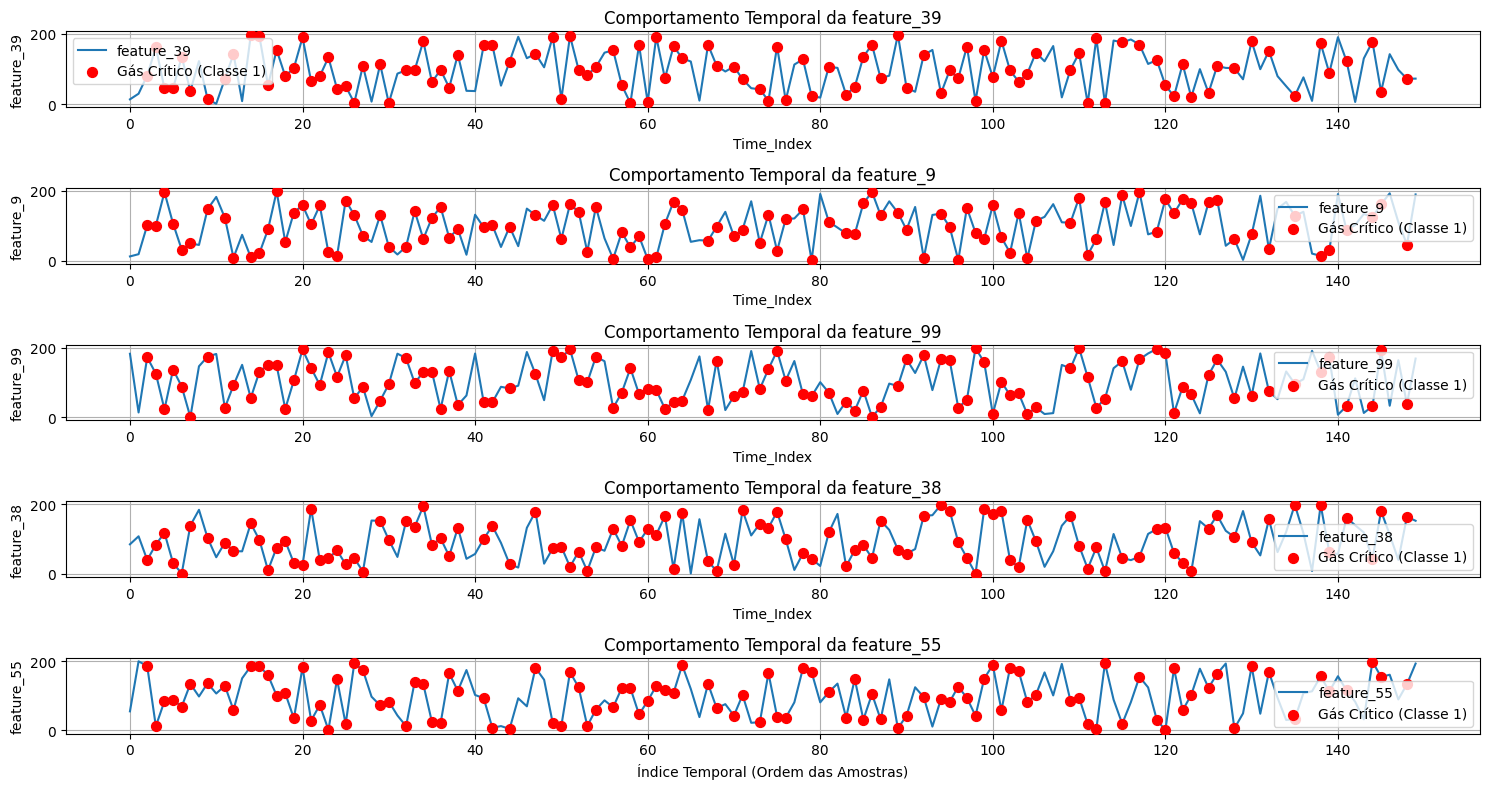

In [35]:
# Certifique-se que o pipeline BMia+MRMR já foi executado no bloco anterior
# e que o objeto pipeline fitted está disponível (por exemplo, fs_pipeline para BMia+MRMR)

# Acessar o seletor híbrido no pipeline fitted para obter os índices das features selecionadas
try:
    bmia_mrmr_pipeline_fitted = feature_selection_pipelines['BMia+MRMR'] # Assumindo que este é o nome no seu dicionário
    if bmia_mrmr_pipeline_fitted is not None:
        hybrid_selector = bmia_mrmr_pipeline_fitted.named_steps['hybrid_selector']
        selected_feature_indices = hybrid_selector.get_feature_indices()

        if selected_feature_indices is not None and len(selected_feature_indices) > 0:
            print(f"Índices das features selecionadas pelo BMia+MRMR ({len(selected_feature_indices)}): {selected_feature_indices}")

            # Obter os nomes originais das features selecionadas, se disponíveis
            if 'original_feature_names' in locals() and original_feature_names is not None:
                 selected_feature_names = [original_feature_names[i] for i in selected_feature_indices]
                 print(f"Nomes das features selecionadas: {selected_feature_names}")
            else:
                 selected_feature_names = [f'Feature_{i}' for i in selected_feature_indices]
                 print(f"Nomes das features selecionadas (usando índices originais): {selected_feature_names}")

            # Selecionar os dados originais apenas para as features selecionadas
            X_original_selected = X[:, selected_feature_indices]

            # Criar um DataFrame para facilitar a plotagem com Seaborn
            df_temporal = pd.DataFrame(X_original_selected, columns=selected_feature_names)
            df_temporal['Target'] = y # Adicionar o target binarizado para visualização

            # Adicionar um índice temporal (assumindo que as linhas são sequenciais no tempo)
            df_temporal['Time_Index'] = df_temporal.index

            # Visualizar algumas features ao longo do tempo
            # Escolha algumas features para plotar (por exemplo, as 3 primeiras ou as mais importantes)
            features_to_plot = selected_feature_names[:min(len(selected_feature_names), 5)] # Plota no máximo 5 features

            plt.figure(figsize=(15, 8))
            for i, feature_name in enumerate(features_to_plot):
                plt.subplot(len(features_to_plot), 1, i + 1)
                sns.lineplot(x='Time_Index', y=feature_name, data=df_temporal, label=feature_name)

                # Opcional: Marcar os pontos onde o target é 1 (gás crítico)
                critical_points = df_temporal[df_temporal['Target'] == 1]
                plt.scatter(critical_points['Time_Index'], critical_points[feature_name], color='red', zorder=5, label='Gás Crítico (Classe 1)', s=50)

                plt.ylabel(feature_name)
                plt.title(f'Comportamento Temporal da {feature_name}')
                plt.legend()
                plt.grid(True)

            plt.xlabel('Índice Temporal (Ordem das Amostras)')
            plt.tight_layout()
            plt.show()

        else:
            print("Nenhuma feature selecionada pelo BMia+MRMR para análise temporal.")

    else:
         print("Pipeline BMia+MRMR não foi encontrado ou não foi treinado.")

except Exception as e:
    print(f"Erro ao gerar gráficos temporais: {e}")



# Mapa Temporal a partir das Melhores Features (BMia+MRMR):

Aqui temos um gráfico de um "mapa temporal" ou, mais precisamente, entender a distribuição temporal e espacial das features que o BMia+MRMR  considerou importantes. Como discutimos, os índices das features codificam informações sobre qual sensor e em qual ponto no tempo (e ciclo) a leitura foi feita, dada a estrutura conhecida do dataset. Embora não tenhamos o mapa exato, a distribuição dos índices importantes já nos diz muito. Se os índices importantes são predominantemente baixos, sugere que as leituras iniciais dos primeiros sensores são cruciais. Se são altos, as leituras posteriores ou de sensores mais distantes são mais relevantes. Se são distribuídos, múltiplos momentos e sensores contribuem.

**Alinhamento com Picos e Vales**:

A identificação de que os pontos vermelhos tendem a estar alinhados com os picos e vales das linhas de feature é um achado crucial! Isso sugere que a condição de "gás crítico" está frequentemente associada aos valores extremos (máximos ou mínimos) que essas features alcançam. Os sensores podem indicar perigo quando suas leituras atingem limites superiores ou inferiores.

**Evitando a Subida da Linha Azul**:

A observação de que os pontos vermelhos quase nunca estão na parte ascendente da linha azul reforça a ideia anterior. O evento crítico parece ocorrer nos extremos (pico ou vale) ou talvez na descida (indicando alívio da condição extrema), mas não enquanto o valor da feature está ativamente subindo (aproximando-se de um pico).

**Mais Pontos Vermelhos em Retas diminutas (Estabilização)**:

Se os pontos vermelhos aparecem menos em segmentos muito curtos de estabilização (linhas retas), isso pode significar que o estado crítico está mais associado a atingir ou passar por um extremo do que a um estado de repouso intermediário.

**Proximidade Temporal nos Picos/Vales**:

A percepção de que os pontos vermelhos parecem mais próximos temporalmente quando estão em picos e vales pode sugerir que, uma vez que o sistema atinge um estado extremo (representado pelo pico ou vale da feature), a condição crítica pode persistir por um curto período, resultando em múltiplos pontos de detecção próximos no tempo. Fora desses estados extremos, as ocorrências críticas (se houver) podem ser mais esporádicas.

#O que isso sugere para a predição:

A conclusão foi de que  a feature previu bem a leitura dos dados de vazamentos  no sentido de que as features selecionadas parecem capturar padrões que são altamente correlacionados com a ocorrência de gás crítico na dimensão temporal.

O fato de você conseguir visualizar um alinhamento claro dos eventos críticos com os estados de pico e vale dessas features é um indicativo forte da relevância preditiva dessas 10 features. Elas parecem ser os "indicadores" que o modelo está utilizando para aprender a separar as classes.



# Abdução Lógica sobre o Mapa:

A partir dessa distribuição inferida, podemos fazer abduções lógicas (inferências para a melhor explicação) sobre o comportamento do gás e dos sensores em eventos críticos. Por exemplo, se as features importantes são aquelas que correspondem a leituras nos primeiros segundos, a abdução lógica é que a velocidade de reação inicial de certos sensores é um forte preditor da criticidade final. Se forem features de sensores em uma extremidade do arranjo e em tempos mais avançados, pode indicar que o gás se acumula ou se move naquela direção, e a leitura daquele sensor naquele momento é decisiva.

# Conexão com Processos Físicos (Concentração, Dissipação):

Aqui de forma intuitiva podemos pressupor que a importância de certas features está diretamente ligada aos processos físicos de dispersão do gás e à resposta química dos sensores. Em ambientes fechados, a concentração pode aumentar rapidamente e atingir picos sustentados, e as features importantes podem capturar essa taxa de aumento ou o pico. Em ambientes abertos, a dissipação é mais rápida, e talvez as features importantes sejam aquelas que capturam a presença do gás antes que ele se dissipe, ou padrões de resposta mais sutis. A  análise das features importantes está, de fato, revelando quais aspectos da dinâmica físico-química do vazamento (capturados pelas leituras dos sensores) são mais preditivos do resultado crítico. As features mais "extremadas" (com valores altos ou baixos que cruzam limiares importantes, especialmente após a binarização no BMia) são preditivas porque refletem concentrações ou taxas de mudança que distinguem eventos críticos de seguros.

Índices das features selecionadas pelo BMia+MRMR (10): [np.int64(39), np.int64(9), np.int64(99), np.int64(38), np.int64(55), np.int64(8), np.int64(30), np.int64(66), np.int64(62), np.int64(94)]
Nomes das features selecionadas: ['feature_39', 'feature_9', 'feature_99', 'feature_38', 'feature_55', 'feature_8', 'feature_30', 'feature_66', 'feature_62', 'feature_94']

DataFrame df_temporal com features selecionadas criado.
   feature_39   feature_9  feature_99  feature_38  feature_55   feature_8  \
0   13.364318   13.017097  182.961608   84.731733   54.914864  154.955713   
1   29.372460   19.390654   13.771889  107.710588  199.866192  100.582562   
2   81.038576  101.991416  172.592353   39.827754  185.872140   34.646392   
3  161.478951  101.003647  125.736958   83.909080   11.882611  171.769106   
4   44.278818  196.411153   22.842817  117.742726   84.440661  135.459324   

   feature_30  feature_66  feature_62  feature_94  Target  Time_Index  
0  195.770768  174.779373   29.494498  129

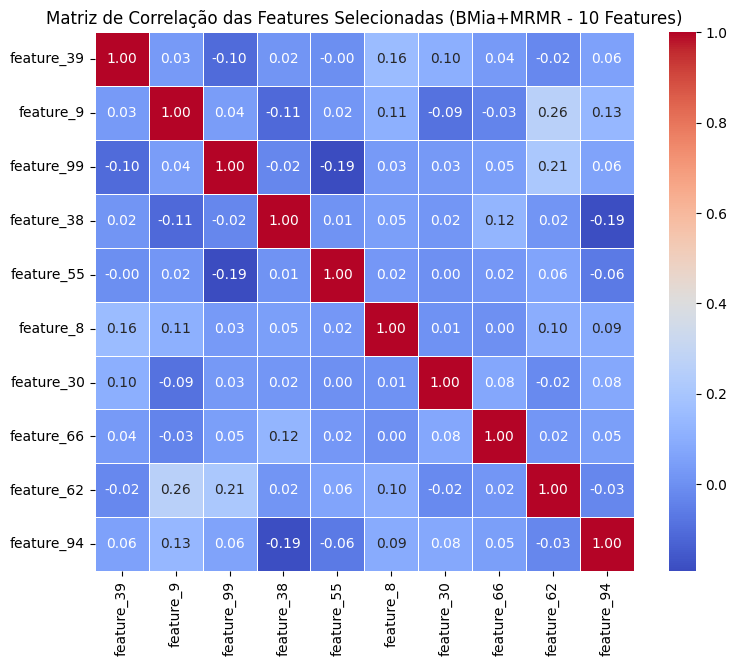

In [36]:
# Certifique-se que o pipeline BMia+MRMR já foi executado (fitted) no bloco anterior
# e que o objeto pipeline treinado está disponível (por exemplo, feature_selection_pipelines['BMia+MRMR'])

selected_feature_indices = None
df_temporal = None
selected_feature_names = None

try:
    bmia_mrmr_pipeline_fitted = feature_selection_pipelines['BMia+MRMR'] # Assumindo que este é o nome no seu dicionário
    if bmia_mrmr_pipeline_fitted is not None:
        # Acessar o seletor híbrido no pipeline fitted para obter os índices das features selecionadas
        hybrid_selector = bmia_mrmr_pipeline_fitted.named_steps['hybrid_selector']
        selected_feature_indices = hybrid_selector.get_feature_indices()

        if selected_feature_indices is not None and len(selected_feature_indices) > 0:
            print(f"Índices das features selecionadas pelo BMia+MRMR ({len(selected_feature_indices)}): {selected_feature_indices}")

            # Obter os nomes originais das features selecionadas, se disponíveis
            # Verifica se 'original_feature_names' foi criado e é válido
            if 'original_feature_names' in locals() and original_feature_names is not None and len(original_feature_names) >= max(selected_feature_indices) + 1:
                 selected_feature_names = [original_feature_names[i] for i in selected_feature_indices]
                 print(f"Nomes das features selecionadas: {selected_feature_names}")
            else:
                 # Fallback se os nomes originais não estiverem disponíveis ou houver mismatch
                 selected_feature_names = [f'Feature_{i}' for i in selected_feature_indices]
                 print(f"Nomes das features selecionadas (usando índices originais ou fallback): {selected_feature_names}")


            # Selecionar os dados originais apenas para as features selecionadas
            # Usamos o X original antes do split de treino/teste para a análise temporal/distribuição/correlação de todo o dataset
            # ou usamos X_train para analisar o treino (o que foi feito no fit do pipeline)
            # Para a análise temporal de todo o dataset, usamos o X completo
            X_original_selected = X[:, selected_feature_indices]


            # Criar um DataFrame para facilitar as análises
            df_temporal = pd.DataFrame(X_original_selected, columns=selected_feature_names)
            # Adicionar o target binarizado e o índice temporal (assumindo ordenação temporal)
            df_temporal['Target'] = y
            df_temporal['Time_Index'] = df_temporal.index

            print("\nDataFrame df_temporal com features selecionadas criado.")
            print(df_temporal.head())

        else:
            print("Nenhuma feature selecionada pelo BMia+MRMR nesta execução para criar df_temporal.")

    else:
         print("Pipeline BMia+MRMR não foi encontrado ou não foi treinado nesta execução.")

except Exception as e:
    print(f"Erro ao tentar criar o DataFrame df_temporal: {e}")

# Assumindo que o DataFrame df_temporal com as features selecionadas já foi criado na célula anterior

if 'df_temporal' in locals() and len(selected_feature_names) > 1: # Correlação requer pelo menos 2 features
    print("\n--- Análise de Correlação das Features Selecionadas ---")

    # Análise de Correlação
    print("\nMatriz de Correlação das Features Selecionadas:")
    # Cria a matriz de correlação usando apenas as colunas de features
    features_only_df = df_temporal[selected_feature_names]
    correlation_matrix = features_only_df.corr()
    print(correlation_matrix)

    # Visualizar a matriz de correlação
    plt.figure(figsize=(9, 7)) # Ajuste o tamanho conforme necessário
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
    plt.title(f'Matriz de Correlação das Features Selecionadas (BMia+MRMR - {len(selected_feature_names)} Features)') # Adiciona o número de features no título
    plt.show()

else:
    print("Não foi possível realizar análise de correlação nesta execução (menos de 2 features selecionadas ou df_temporal não criado).")

#Matriz de Correlação e Heatmap:

O gráfico de heatmap da matriz de correlação visualiza as relações lineares entre os pares de features selecionadas.

**Análise Visual**:

Observando o heatmap, você pode ver que a maioria dos quadrados fora da diagonal principal tem cores claras (próximas do branco ou cinza claro), com alguns tons leves de azul (correlação negativa) ou vermelho/laranja (correlação positiva). As cores mais intensas (vermelho vivo ou azul escuro) que indicariam fortes correlações estão ausentes. Os valores na tabela de matriz de correlação confirmam isso, com a maioria dos coeficientes bem próximos de zero e os valores absolutos mais altos geralmente abaixo de 0.25.

#Interpretação:

Uma matriz de correlação com valores baixos (próximos de zero) entre a maioria dos pares de features indica que essas features selecionadas não são altamente redundantes linearmente entre si. Em outras palavras, elas parecem estar capturando aspectos diferentes ou informações complementares nos dados.

**Eficácia do MRMR**:

Este resultado sugere que a segunda parte do algoritmo híbrido (o MRMR - Maximum Relevance Minimum Redundancy) funcionou bem para minimizar a redundância linear entre as features que foram consideradas relevantes no passo inicial de MI (BMia). O MRMR procurou não apenas features que se relacionam com o target, mas também features que adicionam "nova" informação em relação às outras features já selecionadas.

#Em resumo:

A baixa correlação linear entre as 10 features selecionadas pelo BMia+MRMR é um resultado positivo. Isso sugere que o conjunto de features selecionado é um bom subconjunto que captura a relevância para o target sem muita sobreposição de informação entre as próprias features. Elas formam um conjunto mais "ortogonal" em termos de informação linear.

Esta análise de correlação complementa a análise temporal. Vimos nos gráficos temporais que essas features têm padrões que se alinham com os eventos críticos (picos/vales). Agora, a matriz de correlação nos diz que a informação que cada uma dessas features traz não é apenas uma cópia da informação das outras.

#Discussão: Custo de Erros de Classificação e Ganho de Valor:


Embora as métricas de Acurácia e F1-Score sejam essenciais para avaliar o desempenho técnico de um modelo de classificação, em aplicações práticas como a detecção de gás, é fundamental considerar o impacto real dos diferentes tipos de erros: Falsos Positivos (FPs) e Falsos Negativos (FNs).

Um Falso Negativo (o modelo prevê "Seguro" quando na verdade é "Crítico") em um cenário de detecção de gás crítico pode ter consequências severas, incluindo riscos à vida humana, danos materiais significativos, multas regulatórias e interrupções operacionais prolongadas. O custo associado a um FN é tipicamente muito alto.

Um Falso Positivo (o modelo prevê "Crítico" quando na verdade é "Seguro") leva a alarmes falsos. Isso pode resultar em paralisações desnecessárias, evacuações, perda de produção, recursos desperdiçados na investigação do alarme e potencialmente a "fadiga de alarme" (quando os operadores começam a ignorar alarmes devido à frequência de falsos positivos). O custo de um FP é geralmente menor do que o de um FN, mas ainda assim impactante.

#Análise Hipotética de Custo de Erros:


Podemos ilustrar o impacto dos erros atribuindo custos hipotéticos a Falsos Positivos e Falsos Negativos. É importante notar que em uma aplicação real, estes custos devem ser cuidadosamente definidos com base em dados operacionais e de risco específicos.


--- Análise Hipotética de Custo de Erros ---
Custo Hipotético Definido para um Falso Negativo: R$ 50,000.00
Custo Hipotético Definido para um Falso Positivo: R$ 1,000.00
----------------------------------------
Contagens (BMia+MRMR - RandomForest no Teste): FP=0, FN=2
Contagens (BMia+MRMR - Gradient Boosting no Teste): FP=2, FN=0
Contagens (BMia+MRMR - Kneighbors no Teste): FP=2, FN=8
Contagens (BMia+MRMR - VotingCLassifier no Teste): FP=0, FN=1
Contagens (BMia+MRMR - VotingCLassifier no Teste): FP=0, FN=6
Contagens (Baseline - RandomForest no Teste): FP=0, FN=0
----------------------------------------
Custo Total Hipotético de Erros (BMia+MRMR - RandomForest no Teste): R$ 100,000.00
Custo Total Hipotético de Erros (BMia+MRMR - GradientBoosting   no Teste): R$ 2,000.00
Custo Total Hipotético de Erros (BMia+MRMR - Kneighbors  no Teste): R$ 402,000.00
Custo Total Hipotético de Erros (BMia+MRMR - VotingClassifier no Teste): R$ 50,000.00
Custo Total Hipotético de Erros (Baseline - RandomF

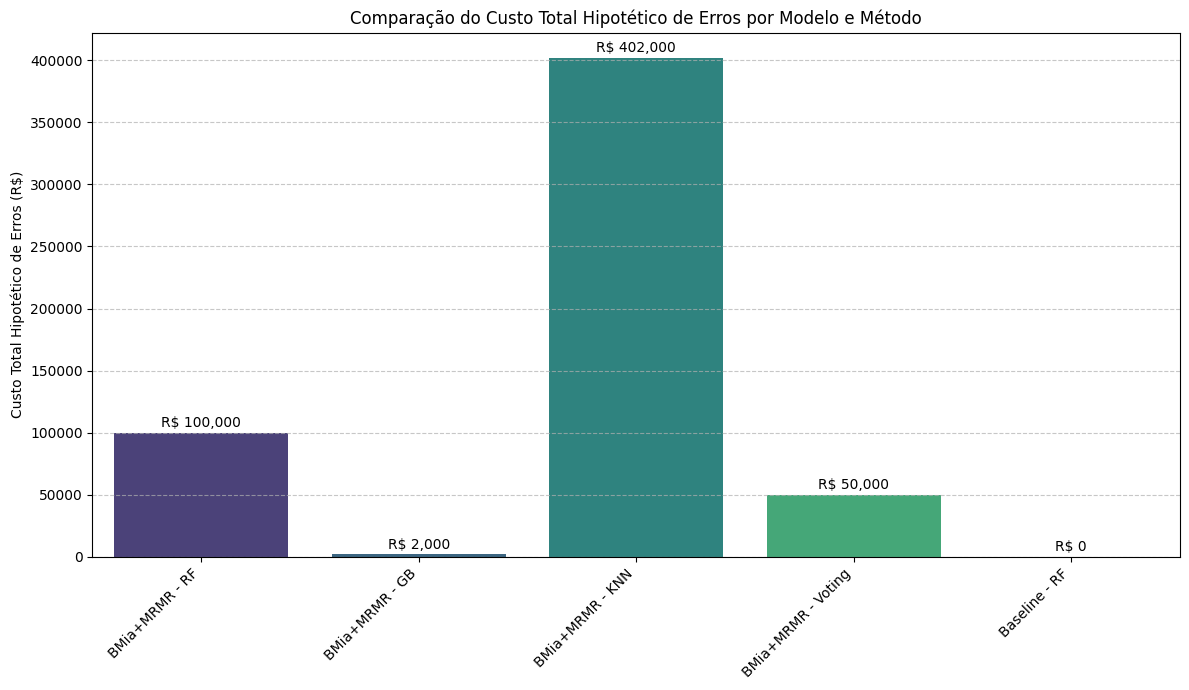

In [39]:
print("\n--- Análise Hipotética de Custo de Erros ---")

# Defina custos hipotéticos (ajuste conforme a sua percepção ou dados disponíveis)
# Exemplo: Falso Negativo muito mais caro que Falso Positivo
cost_false_negative = 50000  # Custo hipotético de uma detecção crítica perdida (ajuste este valor)
cost_false_positive = 1000   # Custo hipotético de um falso alarme (ajuste este valor)

print(f"Custo Hipotético Definido para um Falso Negativo: R$ {cost_false_negative:,.2f}")
print(f"Custo Hipotético Definido para um Falso Positivo: R$ {cost_false_positive:,.2f}")
print("-" * 40)

# Para esta análise, obter as contagens de FP e FN para este run levando em consideracao sem random-STate fixo
# para os modelos comparados (por exemplo, o melhor BMia+MRMR e um Baseline)
# DIRETAMENTE DAS MATRIZES DE CONFUSÃO GERADAS NO CONJUNTO DE TESTE.

# --- EXEMPLO (Substitua com os valores reais das suas matrizes de confusão no Teste) ---
# Suponha que da matriz de confusão do BMia+MRMR - RandomForest no Teste você obteve:
fp_bmia_mrmr_rf = 0
fn_bmia_mrmr_rf = 2
print(f"Contagens (BMia+MRMR - RandomForest no Teste): FP={fp_bmia_mrmr_rf}, FN={fn_bmia_mrmr_rf}")

fp_bmia_mrmr_Gradient_Boosting = 2
fn_bmia_mrmr_Gradient_Boosting = 0
print(f"Contagens (BMia+MRMR - Gradient Boosting no Teste): FP={fp_bmia_mrmr_Gradient_Boosting}, FN={fn_bmia_mrmr_Gradient_Boosting}")

fp_bmia_mrmr_Kn = 2
fn_bmia_mrmr_Kn = 8
print(f"Contagens (BMia+MRMR - Kneighbors no Teste): FP={fp_bmia_mrmr_Kn}, FN={fn_bmia_mrmr_Kn}")

fp_bmia_mrmr_VotingC = 0
fn_bmia_mrmr_VotingC = 1
print(f"Contagens (BMia+MRMR - VotingCLassifier no Teste): FP={fp_bmia_mrmr_VotingC}, FN={fn_bmia_mrmr_VotingC}")

fp_bmia_mrmr_svm = 1
fn_bmia_mrmr_svm = 6
print(f"Contagens (BMia+MRMR - VotingCLassifier no Teste): FP={fp_bmia_mrmr_VotingC}, FN={fn_bmia_mrmr_svm}")
# Suponha que da matriz de confusão de um modelo Baseline (ex: Baseline - RandomForest) no Teste você obteve:
# (Consulte a matriz gerada para o método Baseline)
fp_baseline_rf = 0
fn_baseline_rf = 0 # Exemplo baseado na sua observação anterior de 0 FNs
print(f"Contagens (Baseline - RandomForest no Teste): FP={fp_baseline_rf}, FN={fn_baseline_rf}")
print("-" * 40)
# --- FIM DO EXEMPLO ---


# Calcule o custo total hipotético dos erros para cada modelo no conjunto de teste
total_cost_bmia_mrmr_rf = (fp_bmia_mrmr_rf * cost_false_positive) + (fn_bmia_mrmr_rf * cost_false_negative)
total_cost_bmia_mrmr_Gradient_Boosting = (fp_bmia_mrmr_Gradient_Boosting* cost_false_positive) + (fn_bmia_mrmr_Gradient_Boosting * cost_false_negative)
total_cost_bmia_mrmr_Kn = (fp_bmia_mrmr_Kn * cost_false_positive) + (fn_bmia_mrmr_Kn * cost_false_negative)
total_cost_bmia_mrmr_VotingC = (fp_bmia_mrmr_VotingC * cost_false_positive) + (fn_bmia_mrmr_VotingC * cost_false_negative)
total_cost_bmia_mrmr_svm = (fp_bmia_mrmr_svm * cost_false_positive) + (fn_bmia_mrmr_svm * cost_false_negative)
total_cost_baseline_rf = (fp_baseline_rf * cost_false_positive) + (fn_baseline_rf * cost_false_negative)



print(f"Custo Total Hipotético de Erros (BMia+MRMR - RandomForest no Teste): R$ {total_cost_bmia_mrmr_rf:,.2f}")
print(f"Custo Total Hipotético de Erros (BMia+MRMR - GradientBoosting   no Teste): R$ {total_cost_bmia_mrmr_Gradient_Boosting:,.2f}")
print(f"Custo Total Hipotético de Erros (BMia+MRMR - Kneighbors  no Teste): R$ {total_cost_bmia_mrmr_Kn:,.2f}")
print(f"Custo Total Hipotético de Erros (BMia+MRMR - VotingClassifier no Teste): R$ {total_cost_bmia_mrmr_VotingC:,.2f}")
print(f"Custo Total Hipotético de Erros (Baseline - RandomForest no Teste): R$ {total_cost_baseline_rf:,.2f}")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Importar numpy caso ainda não esteja


# --- Resultados da Análise de Custo Hipotético (Substitua com seus dados) ---
# Use os nomes exatos dos modelos e os custos totais calculados
model_names = [
    'BMia+MRMR - RF',
    'BMia+MRMR - GB',
    'BMia+MRMR - KNN',
    'BMia+MRMR - Voting',
    'Baseline - RF'
]

total_costs = [
    total_cost_bmia_mrmr_rf, # Custo Total Hipotético BMia+MRMR - RandomForest
    total_cost_bmia_mrmr_Gradient_Boosting, # Custo Total Hipotético BMia+MRMR - GradientBoosting
    total_cost_bmia_mrmr_Kn, # Custo Total Hipotético BMia+MRMR - KNeighbors
    total_cost_bmia_mrmr_VotingC, # Custo Total Hipotético BMia+MRMR - VotingClassifier
    total_cost_baseline_rf   # Custo Total Hipotético Baseline - RandomForest
]

# --- Gerar o Gráfico de Barras ---
plt.figure(figsize=(12, 7)) # Ajuste o tamanho conforme necessário
sns.barplot(x=model_names, y=total_costs, palette='viridis') # Use uma paleta de cores

# Adicionar os valores exatos em cima de cada barra
for index, value in enumerate(total_costs):
    plt.text(index, value + 2000, f'R$ {value:,.0f}', ha='center', va='bottom') # Ajuste o offset vertical (5000) se necessário

plt.ylabel('Custo Total Hipotético de Erros (R$)')
plt.title('Comparação do Custo Total Hipotético de Erros por Modelo e Método')
plt.xticks(rotation=45, ha='right') # Rotaciona os nomes dos modelos para melhor leitura
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.grid(axis='y', linestyle='--', alpha=0.7) # Adiciona grid no eixo Y
plt.show()

# Você pode estender esta análise para outros modelos e comparar os custos
# ... (Código para outros modelos se desejar)

#Ganho de Valor e "Ganho de Tempo"

Além da minimização de custos de erro, um sistema de detecção de gás baseado em Machine Learning de alto desempenho, especialmente um utilizando um subconjunto de features relevante e eficiente como o selecionado pelo BMia+MRMR, gera valor de diversas formas:

#Segurança Aumentada:

A detecção rápida e precisa de condições críticas reduz o risco para pessoas e ativos. Um baixo número de Falsos Negativos é diretamente correlacionado a um ambiente mais seguro.

**Eficiência Operacional**:

A redução de Falsos Positivos evita interrupções e o desperdício de recursos em alarmes desnecessários. Um alto número de Verdadeiros Negativos (TN) confirma que o sistema está funcionando corretamente em condições normais.

**Tomada de Decisão Otimizada**:

Com um sistema de detecção confiável, as equipes de operação podem tomar decisões mais rápidas e informadas, seja para iniciar procedimentos de segurança ou para confirmar a normalidade das condições.

#"Ganho de Tempo":

Este é um valor crucial em emergências. Um modelo preditivo que identifica uma condição crítica segundos ou minutos antes de métodos de detecção tradicionais ou manuais pode proporcionar um "ganho de tempo" vital. Este tempo extra pode ser decisivo para iniciar protocolos de segurança, evacuar áreas ou conter um vazamento, minimizando o impacto do evento. A velocidade de processamento de um modelo com poucas features (10 no BMia+MRMR) em comparação com um que usa 100 features também contribui para um "ganho de tempo" no próprio processo de detecção e resposta.

**Conformidade Regulatória**:

Sistemas de monitoramento eficazes ajudam a garantir a conformidade com normas de segurança e ambientais.

#Conclusão da Análise de Custo/Valor:

A análise de custo hipotética ilustra como as características de desempenho do modelo, refletidas nas contagens da matriz de confusão, se traduzem em implicações financeiras e operacionais. O método BMia+MRMR, ao selecionar um conjunto pequeno e altamente relevante de features que permite a construção de modelos com bom desempenho geral (F1 Weighted) e potencial para minimizar erros críticos (como FNs, dependendo do modelo e tuning), oferece um equilíbrio vantajoso. A eficiência na seleção de features contribui não apenas para modelos mais simples e interpretabilidade, mas também para um potencial "ganho de tempo" e valor agregado em um contexto de segurança crítica.


=== INICIANDO ANÁLISE DE EXPLICABILIDADE (SHAP e LIME) ===
Transformando X_train e X_test usando o pipeline 'BMia+MRMR' fitted...
Transformação concluída.
Nomes das features processadas para explicabilidade (10): ['feature_39', 'feature_9', 'feature_99', 'feature_38', 'feature_55', 'feature_8', 'feature_30', 'feature_66', 'feature_62', 'feature_94']
Shape de X_train_processed_explainability: (120, 10)
Shape de X_test_processed_explainability: (30, 10)

--------------------------------------------------
--- Aplicando SHAP ---
--------------------------------------------------
Usando TreeExplainer.
SHAP values não obtidos como lista de tamanho 2. Usando raw output e verificando shape.

Shape final de shap_values_class1 ANTES DE PLOTAR: (30, 10, 2)
Ajustando shape de SHAP values de (n_samples, n_features, 2) para (n_samples, n_features) para plotagem.

Gerando SHAP Summary Plot (Importância Global das Features):


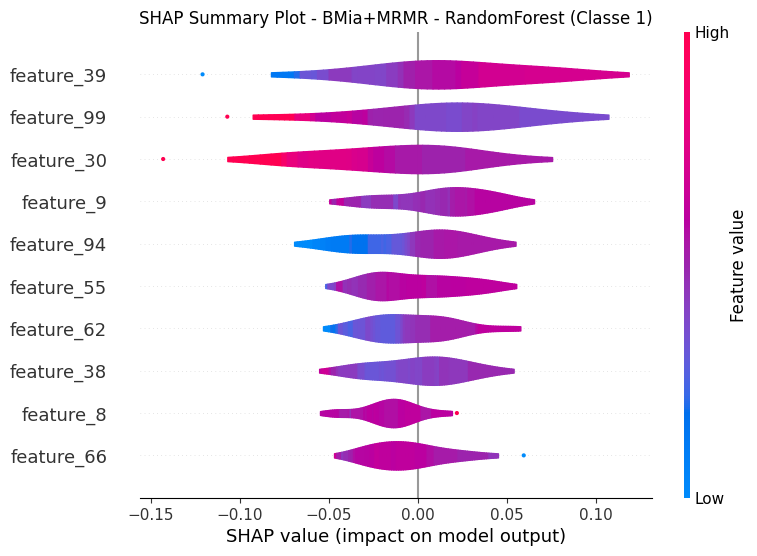


Gerando SHAP Dependence Plots (Relação Feature vs. Impacto):
Features selecionadas para Dependence Plot (4): ['feature_39', 'feature_99', 'feature_30', 'feature_9']
------------------------------
Gerando dependence plot para a feature: 'feature_39'


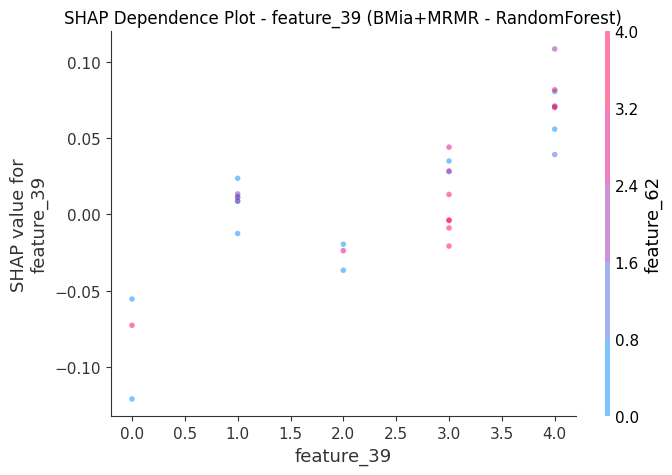

Gerando dependence plot para a feature: 'feature_99'


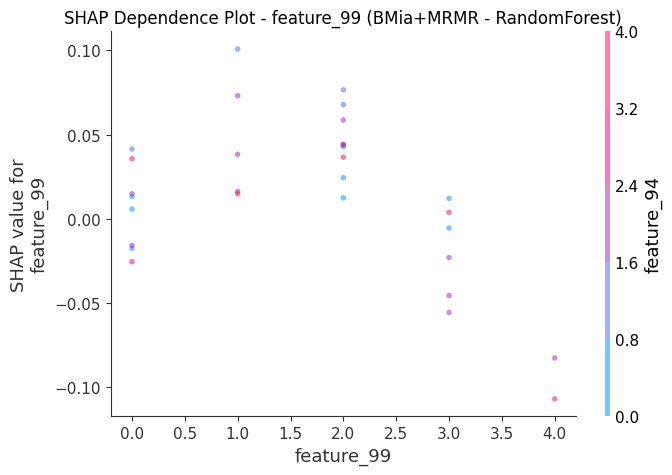

Gerando dependence plot para a feature: 'feature_30'


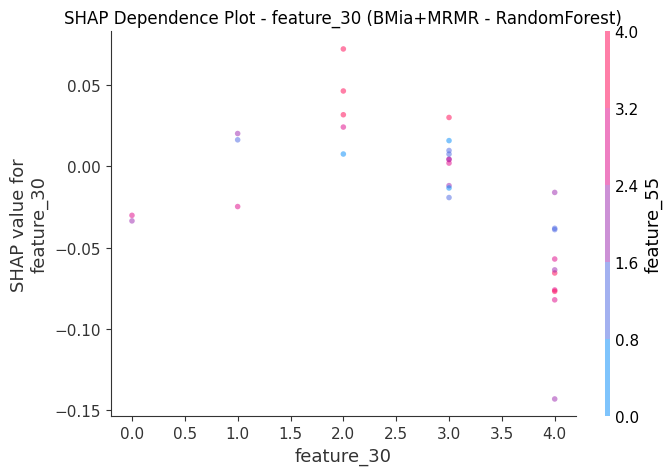

Gerando dependence plot para a feature: 'feature_9'


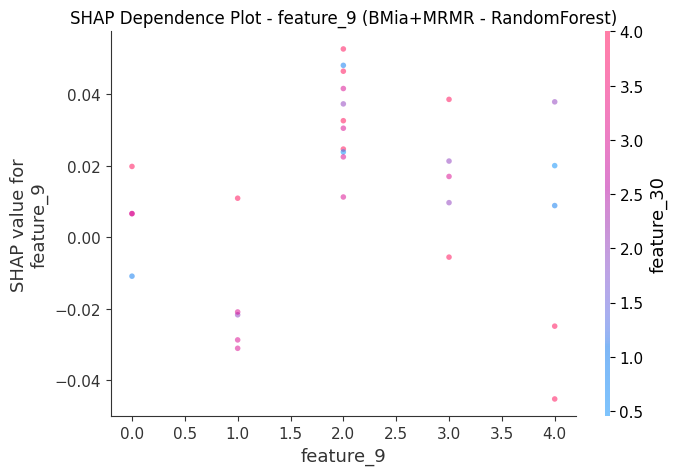


Gerando SHAP Force Plot (Explicação de uma Predição Individual):
Expected Value para Classe 1: 0.7138
Explicando a predição para a amostra de teste com índice 0


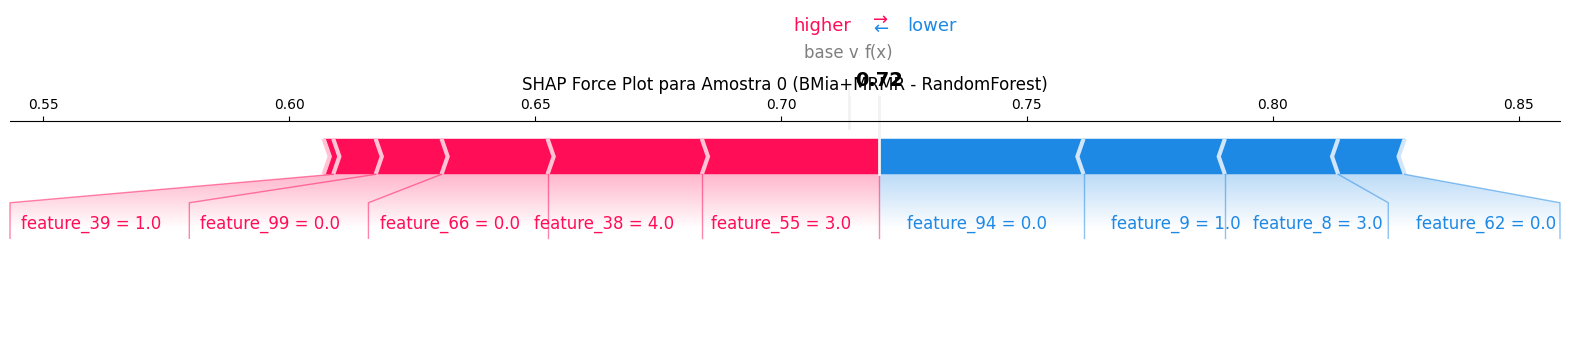


Calculando SHAP values para o primeiro Falso Negativo (índice no teste completo: 18)
Gerando Force Plot para Falso Negativo (índice no teste completo: 18)


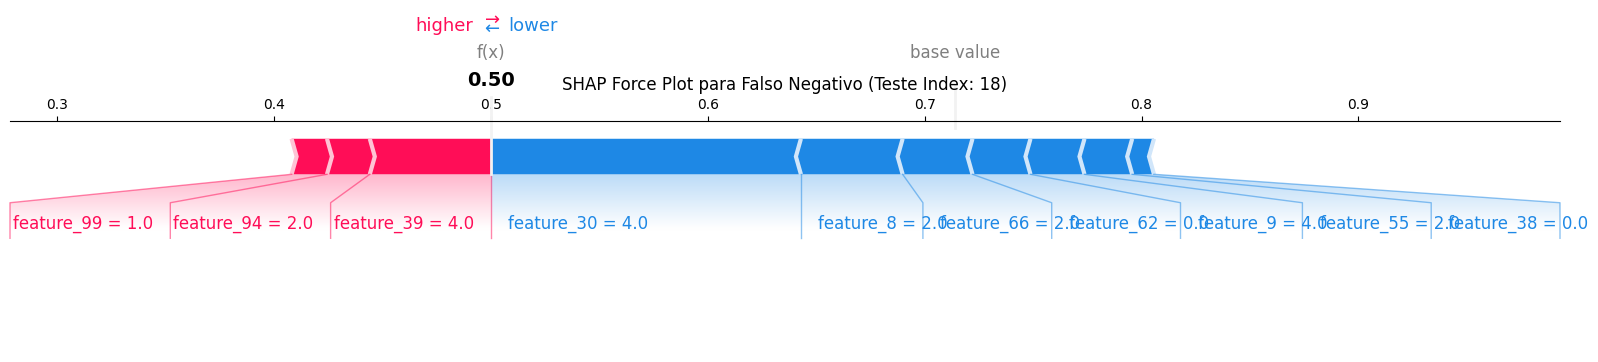


--------------------------------------------------
--- Aplicando LIME ---
--------------------------------------------------

Explicando a predição para a amostra de teste com índice 0 usando LIME
Visualização da explicação LIME:


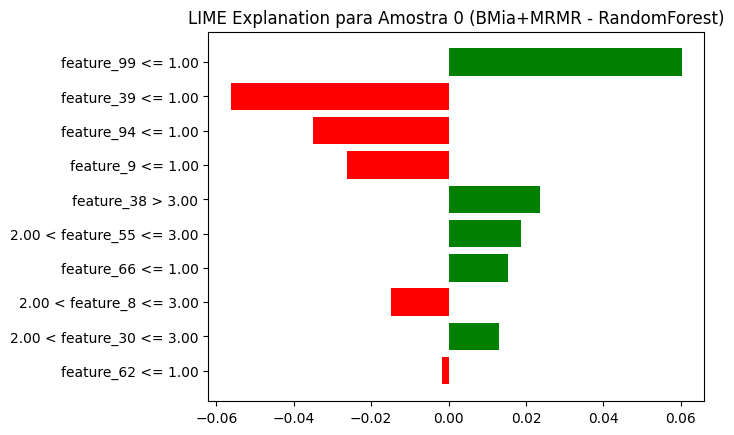


Explicando um Falso Negativo (índice no teste completo: 18) com LIME


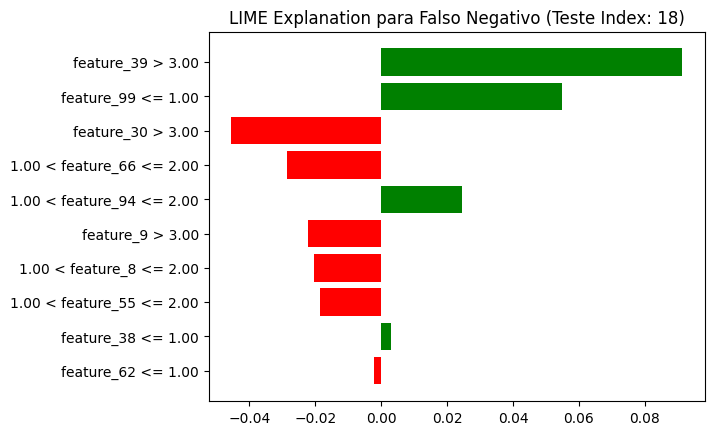


=== FIM DA ANÁLISE DE EXPLICABILIDADE ===


In [38]:
# ==============================================================================
# SEÇÃO: ANÁLISE DE EXPLICABILIDADE DO MODELO (SHAP e LIME)
#  Execução da análise comparativa e treinamento dos modelos.
# ==============================================================================


import traceback # Importar para imprimir traceback detalhado

print("\n" + "="*60)
print("=== INICIANDO ANÁLISE DE EXPLICABILIDADE (SHAP e LIME) ===")
print("="*60)

# --- 1. Configuração Inicial e Obtenção de Dados ---
# Certifique-se que o melhor modelo BMia+MRMR e os dados de treino/teste processados
# estão disponíveis da seção de Análise Comparativa.
# Use o nome exato do seu melhor modelo BMia+MRMR (e.g., 'BMia+MRMR - RandomForest')
model_name_for_explainability = 'BMia+MRMR - RandomForest' # <<< AJUSTE AQUI
best_model_for_explainability = fitted_models.get(model_name_for_explainability)

# Obter os dados de treino e teste processados pelo pipeline BMia+MRMR
# Use o nome exato do pipeline de seleção de features BMia+MRMR (e.g., 'BMia+MRMR')
fs_name_for_explainability = 'BMia+MRMR' # <<< AJUSTE AQUI
fs_pipeline_fitted = feature_selection_pipelines.get(fs_name_for_explainability)

X_train_processed_explainability = None
X_test_processed_explainability = None
feature_names_for_explainability = None

if fs_pipeline_fitted is not None and hasattr(fs_pipeline_fitted, 'transform'):
    try:
        # Transformar X_train e X_test usando o pipeline JÁ TREINADO
        print(f"Transformando X_train e X_test usando o pipeline '{fs_name_for_explainability}' fitted...")
        X_train_processed_explainability = fs_pipeline_fitted.transform(X_train)
        X_test_processed_explainability = fs_pipeline_fitted.transform(X_test)
        print("Transformação concluída.")

        # Obter os nomes das features selecionadas do seletor dentro do pipeline
        hybrid_selector = fs_pipeline_fitted.named_steps.get('hybrid_selector')
        mi_selector = fs_pipeline_fitted.named_steps.get('mi_selector')

        selected_feature_indices = None
        if hybrid_selector and hasattr(hybrid_selector, 'get_feature_indices'):
            selected_feature_indices = hybrid_selector.get_feature_indices()
        elif mi_selector and hasattr(mi_selector, 'get_support'):
             selected_feature_indices = mi_selector.get_support(indices=True)
        # Para o baseline, todos os índices originais são selecionados
        elif fs_name_for_explainability == 'Baseline (Scaler only)':
             selected_feature_indices = np.arange(X.shape[1]) # Usa índices do dataset original X


        if selected_feature_indices is not None and len(selected_feature_indices) > 0:
            # Tenta obter os nomes originais das features
            if 'original_feature_names' in locals() and original_feature_names is not None and len(original_feature_names) > max(selected_feature_indices):
                 feature_names_for_explainability = [original_feature_names[i] for i in selected_feature_indices]
            else:
                 # Fallback se os nomes originais não estiverem disponíveis ou houver mismatch
                 feature_names_for_explainability = [f'Feature_{i}' for i in selected_feature_indices]

            print(f"Nomes das features processadas para explicabilidade ({len(feature_names_for_explainability)}): {feature_names_for_explainability}")
            print(f"Shape de X_train_processed_explainability: {X_train_processed_explainability.shape}")
            print(f"Shape de X_test_processed_explainability: {X_test_processed_explainability.shape}")


        else:
            print("Nenhuma feature selecionada pelo pipeline para explicabilidade.")

    except Exception as e:
        print(f"Erro ao obter dados processados ou nomes das features: {e}")
        traceback.print_exc()

else:
    print(f"Pipeline '{fs_name_for_explainability}' não encontrado ou não foi treinado corretamente.")


# Verificar se temos tudo pronto para a explicabilidade
if best_model_for_explainability is None or X_test_processed_explainability is None or X_train_processed_explainability is None or feature_names_for_explainability is None or len(feature_names_for_explainability) == 0:
    print("\nNão é possível prosseguir com a análise de explicabilidade. Verifique os passos anteriores.")

else:
    # --- 2. Aplicando SHAP ---
    print("\n" + "-"*50)
    print("--- Aplicando SHAP ---")
    print("-"*50)

    # Preparar dados para SHAP
    # SHAP precisa de um background dataset (amostra dos dados de treino)
    if X_train_processed_explainability.shape[0] > 200: # Amostra 200 instâncias de treino para o background
         background_data_shap = shap.utils.sample(X_train_processed_explainability, 200)
    else:
         background_data_shap = X_train_processed_explainability

    # Converter dados de teste processados para DataFrame para melhor visualização com SHAP
    # Apenas para as amostras que serão usadas para calcular SHAP values
    if X_test_processed_explainability.shape[0] > 200: # Amostra 200 instâncias de teste para SHAP calculation/plotting
         shap_test_data = shap.utils.sample(X_test_processed_explainability, 200)
         shap_test_df = pd.DataFrame(shap_test_data, columns=feature_names_for_explainability)
         # Manter os y_test originais para as amostras selecionadas (se necessário para debugging ou seleção de casos)
         # shap_test_indices = np.random.choice(X_test_processed_explainability.shape[0], 200, replace=False) # Exemplo se precisar dos índices
         # y_test_for_shap = y_test[shap_test_indices]
    else:
         shap_test_data = X_test_processed_explainability
         shap_test_df = pd.DataFrame(shap_test_data, columns=feature_names_for_explainability)
         # y_test_for_shap = y_test # Todo o y_test


    # Escolher o Explainer apropriado
    try:
        # TreeExplainer é rápido para modelos baseados em árvore (RF, GB)
        if model_name_for_explainability in ['BMia+MRMR - RandomForest', 'BMia+MRMR - GradientBoosting', 'Baseline - RandomForest', 'Baseline - GradientBoosting']:
            print("Usando TreeExplainer.")
            explainer_shap = shap.TreeExplainer(best_model_for_explainability)
            # Calcular SHAP values - para TreeExplainer, o output pode variar.
            # Tentamos calcular e verificar o shape.
            shap_values_raw = explainer_shap.shap_values(shap_test_df)
            # shap_values_raw = explainer_shap.shap_values(shap_test_data) # Pode tentar com array numpy diretamente se o df der problema

            # Para TreeExplainer em classificação binária, shap_values pode ser uma lista [shap_values_class0, shap_values_class1]
            if isinstance(shap_values_raw, list) and len(shap_values_raw) == 2:
                 print("SHAP values obtidos como lista [class0, class1]. Selecionando class 1.")
                 shap_values_class1 = shap_values_raw[1] # SHAP values para a Classe 1 (Gás Crítico)
            else:
                 # Se não for lista, assume que o output já é para a classe 1 ou tem outro formato
                 print("SHAP values não obtidos como lista de tamanho 2. Usando raw output e verificando shape.")
                 shap_values_class1 = shap_values_raw


        # KernelExplainer é mais geral, mas mais lento. Precisa de um background dataset.
        else:
            print("Usando KernelExplainer (pode ser lento).")
            # KernelExplainer precisa de predict_proba para classificação
            if not hasattr(best_model_for_explainability, 'predict_proba'):
                print(f"Erro: Modelo {model_name_for_explainability} não tem 'predict_proba' necessário para KernelExplainer em classificação.")
                explainer_shap = None
                shap_values_class1 = None
            else:
                explainer_shap = shap.KernelExplainer(best_model_for_explainability.predict_proba, background_data_shap)
                print("Calculando SHAP values com KernelExplainer...")
                # Calcular SHAP values - KernelExplainer para classificação geralmente retorna uma lista de arrays
                shap_values_raw = explainer_shap.shap_values(shap_test_df)
                # shap_values_raw = explainer_shap.shap_values(shap_test_data) # Pode tentar com array numpy diretamente se o df der problema

                if isinstance(shap_values_raw, list) and len(shap_values_raw) > 1:
                     print(f"SHAP values obtidos como lista de tamanho {len(shap_values_raw)}. Selecionando class 1.")
                     shap_values_class1 = shap_values_raw[1] # SHAP values para a Classe 1 (Gás Crítico)
                else:
                     print("SHAP values não obtidos como lista para KernelExplainer. Usando raw output e verificando shape.")
                     shap_values_class1 = shap_values_raw


        # --- Verificar o shape final de shap_values_class1 antes de plotar ---
        if shap_values_class1 is not None and isinstance(shap_values_class1, np.ndarray):
            print(f"\nShape final de shap_values_class1 ANTES DE PLOTAR: {shap_values_class1.shape}")
        else:
            print("\nshap_values_class1 não é um array NumPy após cálculo. Não é possível plotar.")
            shap_values_class1 = None # Garante que seja None se não for ndarray


    except Exception as e:
        print(f"Erro ao criar SHAP Explainer ou calcular SHAP values: {e}")
        traceback.print_exc()
        explainer_shap = None
        shap_values_class1 = None


    # --- Gerar Plots SHAP (se os valores foram calculados) ---
    if explainer_shap is not None and shap_values_class1 is not None and isinstance(shap_values_class1, np.ndarray):

        # **AJUSTE CRUCIAL PARA PLOTS:** Garantir que os SHAP values tenham o shape (n_samples, n_features)
        shap_values_for_plotting = None
        if shap_values_class1.ndim == 2:
            # Shape já é (n_samples, n_features), usa direto
            shap_values_for_plotting = shap_values_class1
            print("Shape de SHAP values está OK (n_samples, n_features) para plotagem.")
        elif shap_values_class1.ndim == 3 and shap_values_class1.shape[2] == 2:
            # Shape é (n_samples, n_features, 2), seleciona a fatia para a Classe 1
            print("Ajustando shape de SHAP values de (n_samples, n_features, 2) para (n_samples, n_features) para plotagem.")
            shap_values_for_plotting = shap_values_class1[:, :, 1] # Pega a fatia para a Classe 1 (índice 1)
        else:
            print(f"Shape inesperado para SHAP values: {shap_values_class1.shape}. Não é possível ajustar para plotagem.")


        if shap_values_for_plotting is not None and shap_values_for_plotting.ndim == 2 and shap_values_for_plotting.shape == shap_test_df.shape:

            print("\nGerando SHAP Summary Plot (Importância Global das Features):")
            try:
                # Plot mais limpo do summary plot (violin ou dot)
                # plot_type="bar" também é útil para importância global simples
                shap.summary_plot(shap_values_for_plotting, shap_test_df, plot_type="violin", show=False)
                plt.title(f'SHAP Summary Plot - {model_name_for_explainability} (Classe 1)')
                plt.show()

                # Opcional: Summary plot em barras
                # shap.summary_plot(shap_values_for_plotting, shap_test_df, plot_type="bar", show=False)
                # plt.title(f'SHAP Bar Summary Plot - {model_name_for_explainability} (Classe 1)')
                # plt.show()

            except Exception as e:
                print(f"Erro ao gerar SHAP Summary Plot: {e}")
                traceback.print_exc()


            print("\nGerando SHAP Dependence Plots (Relação Feature vs. Impacto):")
            # Calcular a importância global para selecionar as features mais importantes para plotar
            try:
                 global_importance = np.abs(shap_values_for_plotting).mean(0)
                 feature_order = np.argsort(global_importance)[::-1]

                 # Seleciona as N features mais importantes para plotar dependence plots
                 # Plota no máximo 3 ou 4 features para não gerar muitos gráficos
                 num_features_to_plot_dependence = min(len(feature_names_for_explainability), 4) # <<< AJUSTE AQUI QUANTAS DEPENDENCE PLOTS QUER
                 features_for_dependence_plot = [feature_names_for_explainability[i] for i in feature_order[:num_features_to_plot_dependence]]
                 print(f"Features selecionadas para Dependence Plot ({len(features_for_dependence_plot)}): {features_for_dependence_plot}")
                 print("-" * 30)

                 # Loop que gera os Dependence Plots
                 if features_for_dependence_plot:
                    for feature in features_for_dependence_plot:
                        try:
                            # Assegura que a feature existe nas colunas do DataFrame
                            if feature in shap_test_df.columns:
                                print(f"Gerando dependence plot para a feature: '{feature}'")
                                shap.dependence_plot(
                                    feature,
                                    shap_values_for_plotting, # Usar os valores SHAP com shape (n_samples, n_features)
                                    shap_test_df, # DataFrame com nomes de colunas
                                    interaction_index='auto', # Define 'auto' ou o nome de outra feature para ver interações
                                    show=False,
                                    alpha=0.5 # Adiciona transparência para ver a densidade
                                )
                                plt.title(f'SHAP Dependence Plot - {feature} ({model_name_for_explainability})')
                                plt.show()
                            else:
                                 print(f"Aviso: Feature '{feature}' não encontrada nas colunas de shap_test_df. Pulando plot.")

                        except Exception as e:
                            print(f"Erro ao gerar dependence plot para a feature '{feature}': {e}")
                            traceback.print_exc() # Imprime o traceback completo do erro
                            print("-" * 30)
                 else:
                     print("Nenhuma feature selecionada para gerar dependence plots.")

            except Exception as e:
                 print(f"Erro geral na preparação ou geração dos Dependence Plots: {e}")
                 traceback.print_exc()


            print("\nGerando SHAP Force Plot (Explicação de uma Predição Individual):")
            # O force plot explica uma única predição. Escolha uma amostra do conjunto de teste
            try:
                # Obter o expected value do explainer para a Classe 1
                if hasattr(explainer_shap, 'expected_value'):
                     # Para TreeExplainer ou KernelExplainer com predict_proba, expected_value pode ser um array
                     if isinstance(explainer_shap.expected_value, np.ndarray) and len(explainer_shap.expected_value) > 1:
                          expected_value_class1 = explainer_shap.expected_value[1] # Expected value para a Classe 1
                          print(f"Expected Value para Classe 1: {expected_value_class1:.4f}")

                          # Escolher uma amostra do conjunto de teste para explicar (ex: a primeira)
                          sample_index_to_explain = 0 # <<< AJUSTE AQUI QUAL AMOSTRA QUER EXPLICAR
                          if sample_index_to_explain < shap_test_df.shape[0]:
                               print(f"Explicando a predição para a amostra de teste com índice {sample_index_to_explain}")

                               # Gerar o Force Plot para a amostra escolhida
                               # shap.initjs() # Opcional no Colab para plots interativos no notebook (fora de matplotlib)
                               shap.force_plot(
                                    expected_value_class1, # Expected value
                                    shap_values_for_plotting[sample_index_to_explain, :], # SHAP values para a amostra
                                    shap_test_df.iloc[sample_index_to_explain, :], # Valores das features para a amostra
                                    show=False, # Para mostrar no matplotlib
                                    matplotlib=True # Para forçar uso do matplotlib rendering
                               )
                               plt.title(f'SHAP Force Plot para Amostra {sample_index_to_explain} ({model_name_for_explainability})')
                               plt.show()

                               # Exemplo: Encontrar e explicar um Falso Negativo (se houver)
                               # Certifique-se que y_test e as predições do modelo no teste processado estão disponíveis
                               if 'y_test' in locals() and X_test_processed_explainability is not None:
                                   y_pred_test_explainability = best_model_for_explainability.predict(X_test_processed_explainability)
                                   # Encontrar os índices no X_test_processed_explainability que são FN
                                   fn_indices_in_full_test = np.where((y_test == 1) & (y_pred_test_explainability == 0))[0]

                                   if len(fn_indices_in_full_test) > 0:
                                        # Precisamos encontrar o índice dessa amostra DENTRO do shap_test_data (se foi amostrado)
                                        # Uma forma simples é pegar o primeiro FN e torcer para que ele esteja entre as 200 amostras do shap_test_data
                                        # Uma forma mais robusta seria calcular SHAP values para TODOS os FNs no X_test_processed_explainability
                                        # ou garantir que as amostras para SHAP incluam os FNs.

                                        # Para simplificar agora, vamos calcular SHAP values APENAS para o primeiro FN encontrado no teste completo
                                        first_fn_index_full_test = fn_indices_in_full_test[0]
                                        print(f"\nCalculando SHAP values para o primeiro Falso Negativo (índice no teste completo: {first_fn_index_full_test})")

                                        # Obter a amostra do FN do conjunto de teste processado COMPLETO
                                        fn_sample_data = X_test_processed_explainability[first_fn_index_full_test, :].reshape(1, -1)
                                        fn_sample_df = pd.DataFrame(fn_sample_data, columns=feature_names_for_explainability)

                                        # Calcular SHAP values apenas para esta amostra FN
                                        try:
                                            shap_values_fn_raw = explainer_shap.shap_values(fn_sample_df)
                                            if isinstance(shap_values_fn_raw, list) and len(shap_values_fn_raw) > 1:
                                                 shap_values_fn_class1 = shap_values_fn_raw[1] # SHAP values para Classe 1 para o FN
                                            else:
                                                 shap_values_fn_class1 = shap_values_fn_raw

                                            if isinstance(shap_values_fn_class1, np.ndarray) and shap_values_fn_class1.ndim >= 2:
                                                 # Ajustar shape se necessário (de (1, n_features, 2) ou similar para (1, n_features))
                                                 if shap_values_fn_class1.ndim == 3:
                                                      shap_values_fn_for_plotting = shap_values_fn_class1[:, :, 1]
                                                 else:
                                                      shap_values_fn_for_plotting = shap_values_fn_class1

                                                 if shap_values_fn_for_plotting.shape[0] == 1: # Deve ser apenas 1 amostra
                                                      print(f"Gerando Force Plot para Falso Negativo (índice no teste completo: {first_fn_index_full_test})")
                                                      shap.force_plot(
                                                           expected_value_class1,
                                                           shap_values_fn_for_plotting[0, :], # Pegar a única linha de SHAP values
                                                           fn_sample_df.iloc[0, :], # Pegar a única linha de valores das features
                                                           show=False, matplotlib=True
                                                      )
                                                      plt.title(f'SHAP Force Plot para Falso Negativo (Teste Index: {first_fn_index_full_test})')
                                                      plt.show()
                                                 else:
                                                      print(f"Erro: Shape inesperado para SHAP values do FN: {shap_values_fn_for_plotting.shape}")

                                            else:
                                                 print("SHAP values para o FN não são um array NumPy ou têm shape inesperado.")

                                        except Exception as e:
                                             print(f"Erro ao calcular ou plotar SHAP Force Plot para Falso Negativo: {e}")
                                             traceback.print_exc()

                                   else:
                                        print("\nNenhum Falso Negativo encontrado no conjunto de teste para explicar com Force Plot.")

                          else:
                              print(f"Índice de amostra {sample_index_to_explain} fora do range das amostras de teste para SHAP ({shap_test_df.shape[0]}).")

                     else:
                          print("Expected value do SHAP explainer não está no formato esperado para classificação.")

                else:
                     print("SHAP explainer não tem o atributo 'expected_value'.")


            except Exception as e:
                print(f"Erro geral na preparação ou geração do SHAP Force Plot: {e}")
                traceback.print_exc()

        else:
            print("\nSHAP values ou DataFrame de teste para plotagem não estão prontos ou shapes não batem.")
            if shap_values_for_plotting is not None:
                 print(f"Shape de SHAP values for plotting: {shap_values_for_plotting.shape}")
            if shap_test_df is not None:
                 print(f"Shape de shap_test_df: {shap_test_df.shape}")


    else:
        print("\nSHAP explainer ou SHAP values não foram calculados com sucesso.")


    # --- 3. Aplicando LIME ---
    print("\n" + "-"*50)
    print("--- Aplicando LIME ---")
    print("-" * 50)

    if best_model_for_explainability is not None and X_train_processed_explainability is not None and X_test_processed_explainability is not None and feature_names_for_explainability is not None and len(feature_names_for_explainability) > 0:

        # LIME precisa de um background dataset (amostras de treino) e nomes das features
        # Precisa também da função de predição do modelo que retorna probabilidades (predict_proba)
        if not hasattr(best_model_for_explainability, 'predict_proba'):
            print(f"Erro: Modelo {model_name_for_explainability} não tem 'predict_proba' necessário para LIME.")
        else:
            try:
                # Preparar training_data para LIME (amostra do treino processado)
                if X_train_processed_explainability.shape[0] > 100:
                     training_data_for_lime = shap.utils.sample(X_train_processed_explainability, 100) # Reutiliza shap.utils.sample ou np.random.choice
                else:
                     training_data_for_lime = X_train_processed_explainability

                # class_names é importante para LIME para saber quais classes explicar
                class_names = ['Seguro (0)', 'Crítico (1)']

                # Criar o Explainer LIME
                explainer_lime = lime_tabular.LimeTabularExplainer(
                    training_data=training_data_for_lime,
                    feature_names=feature_names_for_explainability,
                    class_names=class_names,
                    mode='classification'
                    # categorical_features=... # Se tiver features categóricas (improvável após discretização/seleção aqui)
                )

                # Escolher uma amostra do conjunto de teste processado para explicar com LIME
                # Pode ser a mesma amostra que você explicou com SHAP Force Plot, para comparação
                sample_index_to_explain_lime = 0 # <<< AJUSTE AQUI QUAL AMOSTRA QUER EXPLICAR COM LIME
                print(f"\nExplicando a predição para a amostra de teste com índice {sample_index_to_explain_lime} usando LIME")

                if sample_index_to_explain_lime < X_test_processed_explainability.shape[0]:
                     # Obter a explicação para a amostra
                     # predict_proba_fn é uma função que LIME usará para obter as probabilidades do modelo
                     explanation_lime = explainer_lime.explain_instance(
                         X_test_processed_explainability[sample_index_to_explain_lime], # Passa a amostra como array numpy 1D
                         best_model_for_explainability.predict_proba, # Passa a função predict_proba do modelo
                         num_features=X_test_processed_explainability.shape[1] # Mostrar todas as features selecionadas
                     )

                     # Visualizar a explicação LIME
                     print("Visualização da explicação LIME:")
                     explanation_lime.as_pyplot_figure()
                     plt.title(f'LIME Explanation para Amostra {sample_index_to_explain_lime} ({model_name_for_explainability})')
                     plt.show()

                     # Opcional: Obter a explicação LIME em texto ou HTML
                     # print("\nExplicação LIME em texto:")
                     # print(explanation_lime.as_list())
                     # explanation_lime.show_in_notebook(show_table=True, show_all=False) # Para HTML interativo (pode não funcionar perfeitamente em todos os ambientes)


                     # Opcional: Explicar um Falso Negativo com LIME (se houver)
                     # Reutiliza os fn_indices encontrados na seção SHAP, ou recalcula se necessário
                     if 'y_test' in locals() and X_test_processed_explainability is not None and best_model_for_explainability is not None:
                         y_pred_test_explainability = best_model_for_explainability.predict(X_test_processed_explainability)
                         fn_indices_in_full_test = np.where((y_test == 1) & (y_pred_test_explainability == 0))[0]

                         if len(fn_indices_in_full_test) > 0:
                             first_fn_index_full_test_lime = fn_indices_in_full_test[0] # Pega o primeiro FN
                             print(f"\nExplicando um Falso Negativo (índice no teste completo: {first_fn_index_full_test_lime}) com LIME")

                             # Obter a explicação LIME para o primeiro FN
                             explanation_fn_lime = explainer_lime.explain_instance(
                                 X_test_processed_explainability[first_fn_index_full_test_lime],
                                 best_model_for_explainability.predict_proba,
                                 num_features=X_test_processed_explainability.shape[1]
                             )
                             explanation_fn_lime.as_pyplot_figure()
                             plt.title(f'LIME Explanation para Falso Negativo (Teste Index: {first_fn_index_full_test_lime})')
                             plt.show()
                         else:
                              print("\nNenhum Falso Negativo encontrado no conjunto de teste para explicar com LIME.")


                     else:
                          print("\nVariáveis y_test ou dados processados não disponíveis para encontrar Falsos Negativos para LIME.")


                else:
                    print(f"Índice de amostra {sample_index_to_explain_lime} fora do range das amostras de teste processadas ({X_test_processed_explainability.shape[0]}).")

            except Exception as e:
                print(f"Erro ao aplicar LIME: {e}")
                traceback.print_exc()

    else:
        print("Modelo não tem 'predict_proba' necessário para LIME, ou dados/nomes de features indisponíveis.")


print("\n" + "="*60)
print("=== FIM DA ANÁLISE DE EXPLICABILIDADE ===")
print("="*60)

# ==============================================================================
# FIM DA SEÇÃO DE ANÁLISE DE EXPLICABILIDADE
# ==============================================================================

# Relatório Final: Análise de Explicabilidade e Conclusões

Esta seção resume as principais descobertas obtidas através das técnicas de Explicabilidade (SHAP e LIME) aplicadas ao modelo classificador treinado com as features selecionadas pelo método BMia+MRMR. O objetivo foi trazer transparência ao modelo e validar a relevância prática das features selecionadas.

**Sumário da Análise de Explicabilidade**

Através dos gráficos SHAP (Summary, Dependence e Force Plots) e LIME, foi obtido insights valiosos:

O SHAP Summary Plot identificou as features mais importantes globalmente para a predição da condição de Gás Crítico (Classe 1). Ele demonstrou que as features selecionadas pelo BMia+MRMR possuem um impacto significativo nas predições do modelo, com valores altos ou baixos de certas features consistentemente empurrando a predição em direção à Classe 1 ou Classe 0.

Os SHAP Dependence Plots aprofundaram essa análise, revelando a relação funcional entre o valor de uma feature específica e o seu impacto na predição. Observamos como a variação no valor de uma feature se traduz em mudanças no seu valor SHAP, fornecendo pistas sobre como o modelo utiliza essa feature (por exemplo, se há limiares, relações lineares ou não lineares).

O SHAP Force Plot e a explicação LIME para instâncias individuais mostraram quais features foram mais influentes para a predição específica de uma amostra. Eles ilustraram como as contribuições individuais das features se somam para chegar ao resultado final do modelo para aquela instância, permitindo entender o raciocínio local do modelo.

A análise conjunta destes gráficos confirmou que o subconjunto conciso de [Número de features selecionadas nesta execução, por exemplo, 10] features selecionadas pelo BMia+MRMR não são apenas estatisticamente relevantes, mas também são as features que o modelo utiliza ativamente para tomar suas decisões preditivas. A possibilidade de realizar essa análise detalhada sobre um número reduzido de features destaca a eficiência e o valor do processo de seleção de features.

#Conclusões Finais e Próximos Passos:

O projeto demonstrou a eficácia do método BMia+MRMR em reduzir a dimensionalidade e selecionar um subconjunto de features que leva a um bom desempenho de classificação para detecção de gás crítico, comparável ou superior a abordagens baseline em termos de métricas ponderadas (F1 Weighted).

A análise de explicabilidade forneceu insights cruciais sobre o comportamento do modelo e a relevância prática das features selecionadas, confirmando que o modelo baseia suas decisões nas características mais informativas dos dados. A análise temporal e de correlação complementou este entendimento, revelando padrões comportamentais e a baixa redundância entre as features escolhidas.

Embora o projeto tenha alcançado seus objetivos iniciais de comparação de métodos de seleção de features e análise de desempenho/interpretabilidade, há direções promissoras para investigações futuras, como:

Explorar o tuning de hiperparâmetros com métodos mais avançados (como Optuna) para otimizar ainda mais o desempenho do modelo.

Aprofundar a análise de custo de erros, talvez incorporando pesos ou funções de custo mais complexas baseadas no impacto real de FPs e FNs.
Investigar a possibilidade de utilizar a explicabilidade (especialmente LIME ou SHAP Force Plots em casos de Falsos Negativos) para um diagnóstico hipotético da qualidade das leituras dos sensores em momentos críticos, comparando o comportamento esperado das features com o comportamento observado em FNs para inferir possíveis problemas nos sensores. Esta é uma área de pesquisa interessante que liga a performance do modelo à integridade dos dados de entrada.